## Notes

- Incorrect best hyper params displayed in trials:
  - This is a known issue in keras: https://github.com/keras-team/keras-tuner/issues/656
- Set overwrite = True if you want to retrain the NN models


In [1]:
import matplotlib.pyplot as plt

CMAP = plt.cm.Blues

TEST_SIZE: float = 0.20  # for train-test split
SEED: int = 42  # keras seed
MAX_TRIALS: int = 30  # keras-tuner max_trials for NN models

In [2]:
import pandas as pd
from ucimlrepo import fetch_ucirepo

# fetch dataset
vertebral_column = fetch_ucirepo(id=212)

# data (as pandas dataframes)
X: pd.DataFrame = vertebral_column.data.features
y: pd.DataFrame = vertebral_column.data.targets
df = pd.concat([X, y], axis=1)
df = df.query("degree_spondylolisthesis < 100")
df_binary = df.copy()
df_binary.loc[df_binary["class"] != "Normal", "class"] = "Abnormal"

# metadata
print(vertebral_column.metadata)

# variable information
print(vertebral_column.variables)

{'uci_id': 212, 'name': 'Vertebral Column', 'repository_url': 'https://archive.ics.uci.edu/dataset/212/vertebral+column', 'data_url': 'https://archive.ics.uci.edu/static/public/212/data.csv', 'abstract': 'Data set containing values for six biomechanical features used to classify orthopaedic patients into 3 classes (normal, disk hernia or spondilolysthesis) or 2 classes (normal or abnormal).', 'area': 'Health and Medicine', 'tasks': ['Classification'], 'characteristics': ['Multivariate'], 'num_instances': 310, 'num_features': 6, 'feature_types': ['Real'], 'demographics': [], 'target_col': ['class'], 'index_col': None, 'has_missing_values': 'no', 'missing_values_symbol': None, 'year_of_dataset_creation': 2005, 'last_updated': 'Fri Mar 29 2024', 'dataset_doi': '10.24432/C5K89B', 'creators': ['Guilherme Barreto', 'Ajalmar Neto'], 'intro_paper': None, 'additional_info': {'summary': "Biomedical data set built by Dr. Henrique da Mota during a medical residence period in the Group of Applied R

In [3]:
df = df.query("degree_spondylolisthesis < 100")
df_binary = df.copy()
df_binary.loc[df_binary["class"] != "Normal", "class"] = "Abnormal"

In [4]:
df_binary["class"].value_counts()

class
Abnormal    199
Normal      100
Name: count, dtype: int64

## EDA


### 1. Distribution plots


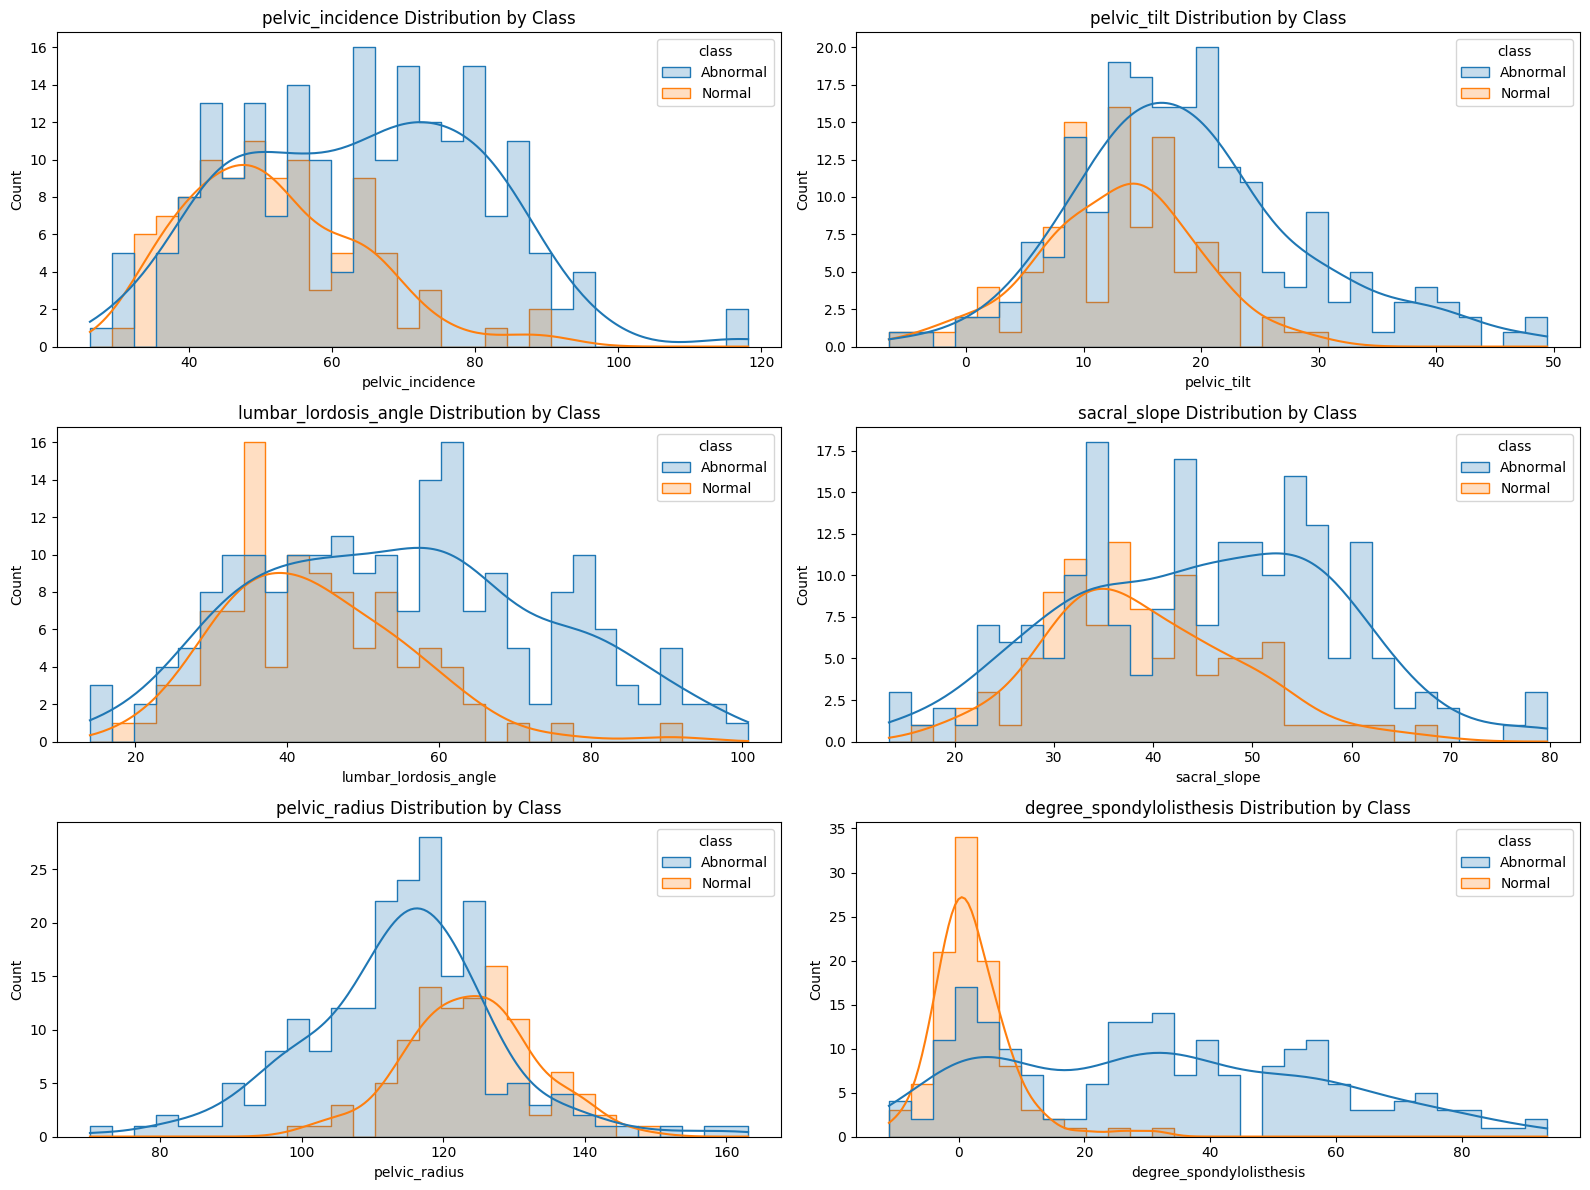

In [5]:
import pandas as pd
import seaborn as sns

# Define the features and the number of rows and columns for the grid
features = [
    "pelvic_incidence",
    "pelvic_tilt",
    "lumbar_lordosis_angle",
    "sacral_slope",
    "pelvic_radius",
    "degree_spondylolisthesis",
]
n_rows = len(features) // 2 + len(features) % 2
n_cols = 2

# Create the figure and axes for the grid
fig, axes = plt.subplots(n_rows, n_cols, figsize=(16, 4 * n_rows))

# Plot histograms for each feature
for idx, feature in enumerate(features):
    row = idx // n_cols
    col = idx % n_cols
    ax = axes[row, col]
    sns.histplot(
        data=df_binary,
        x=feature,
        hue="class",
        kde=True,
        bins=30,
        ax=ax,
        element="step",
    )
    ax.set_title(f"{feature} Distribution by Class")


# Remove empty subplots if the number of features isn't even
if len(features) % 2 != 0:
    fig.delaxes(axes[-1, -1])

plt.tight_layout()
plt.show()

### 2. Box plots


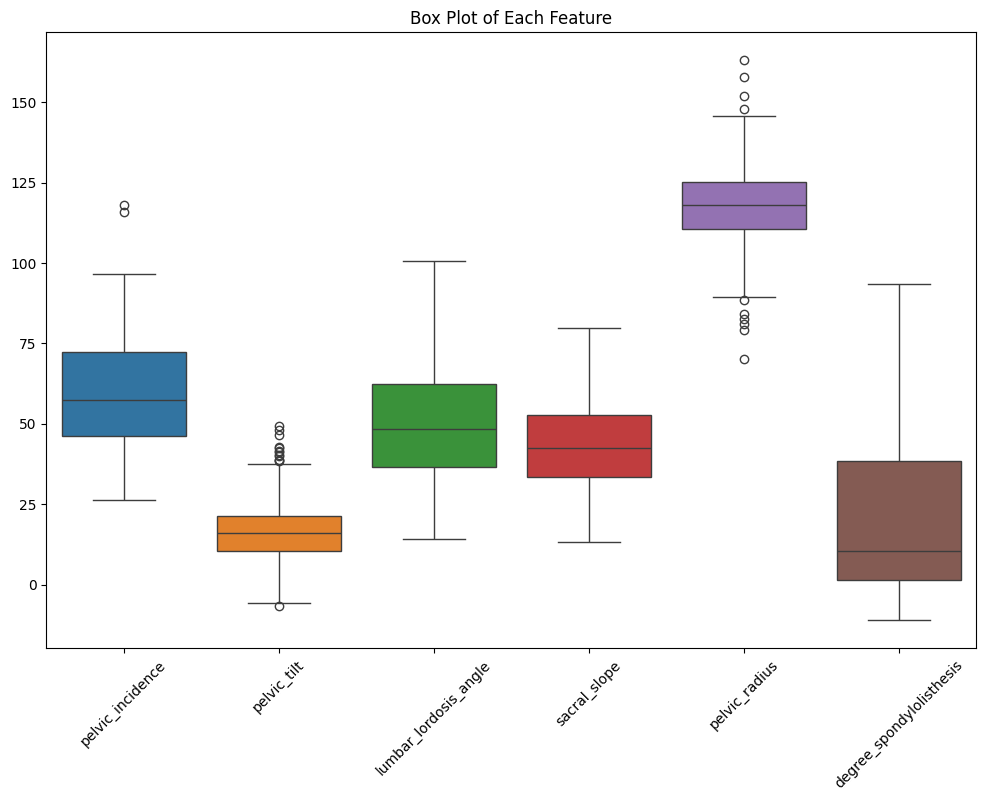

In [6]:
# Box plots to visualize outliers
plt.figure(figsize=(12, 8))
sns.boxplot(data=df_binary[features])
plt.title("Box Plot of Each Feature")
plt.xticks(rotation=45)
plt.show()

### 3. Correlation matrix


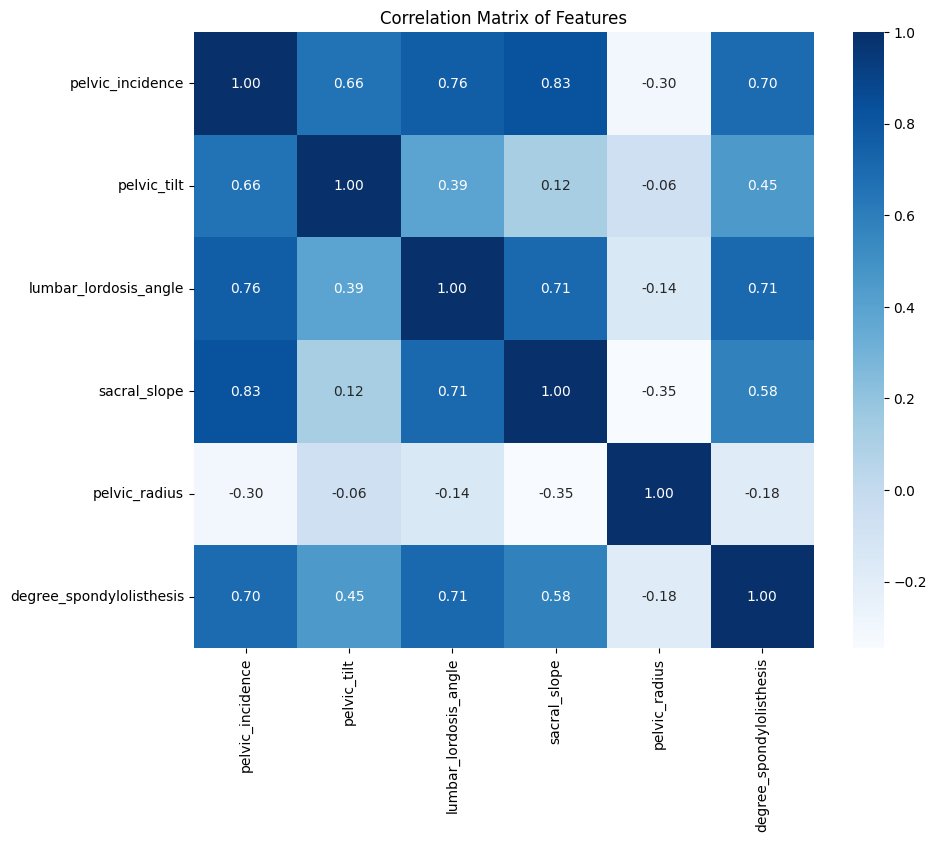

In [7]:
# Correlation Matrix
correlation_matrix = df_binary.drop(columns="class").corr()

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap=CMAP, fmt=".2f")
plt.title("Correlation Matrix of Features")
plt.show()

### 4. Box plot by class


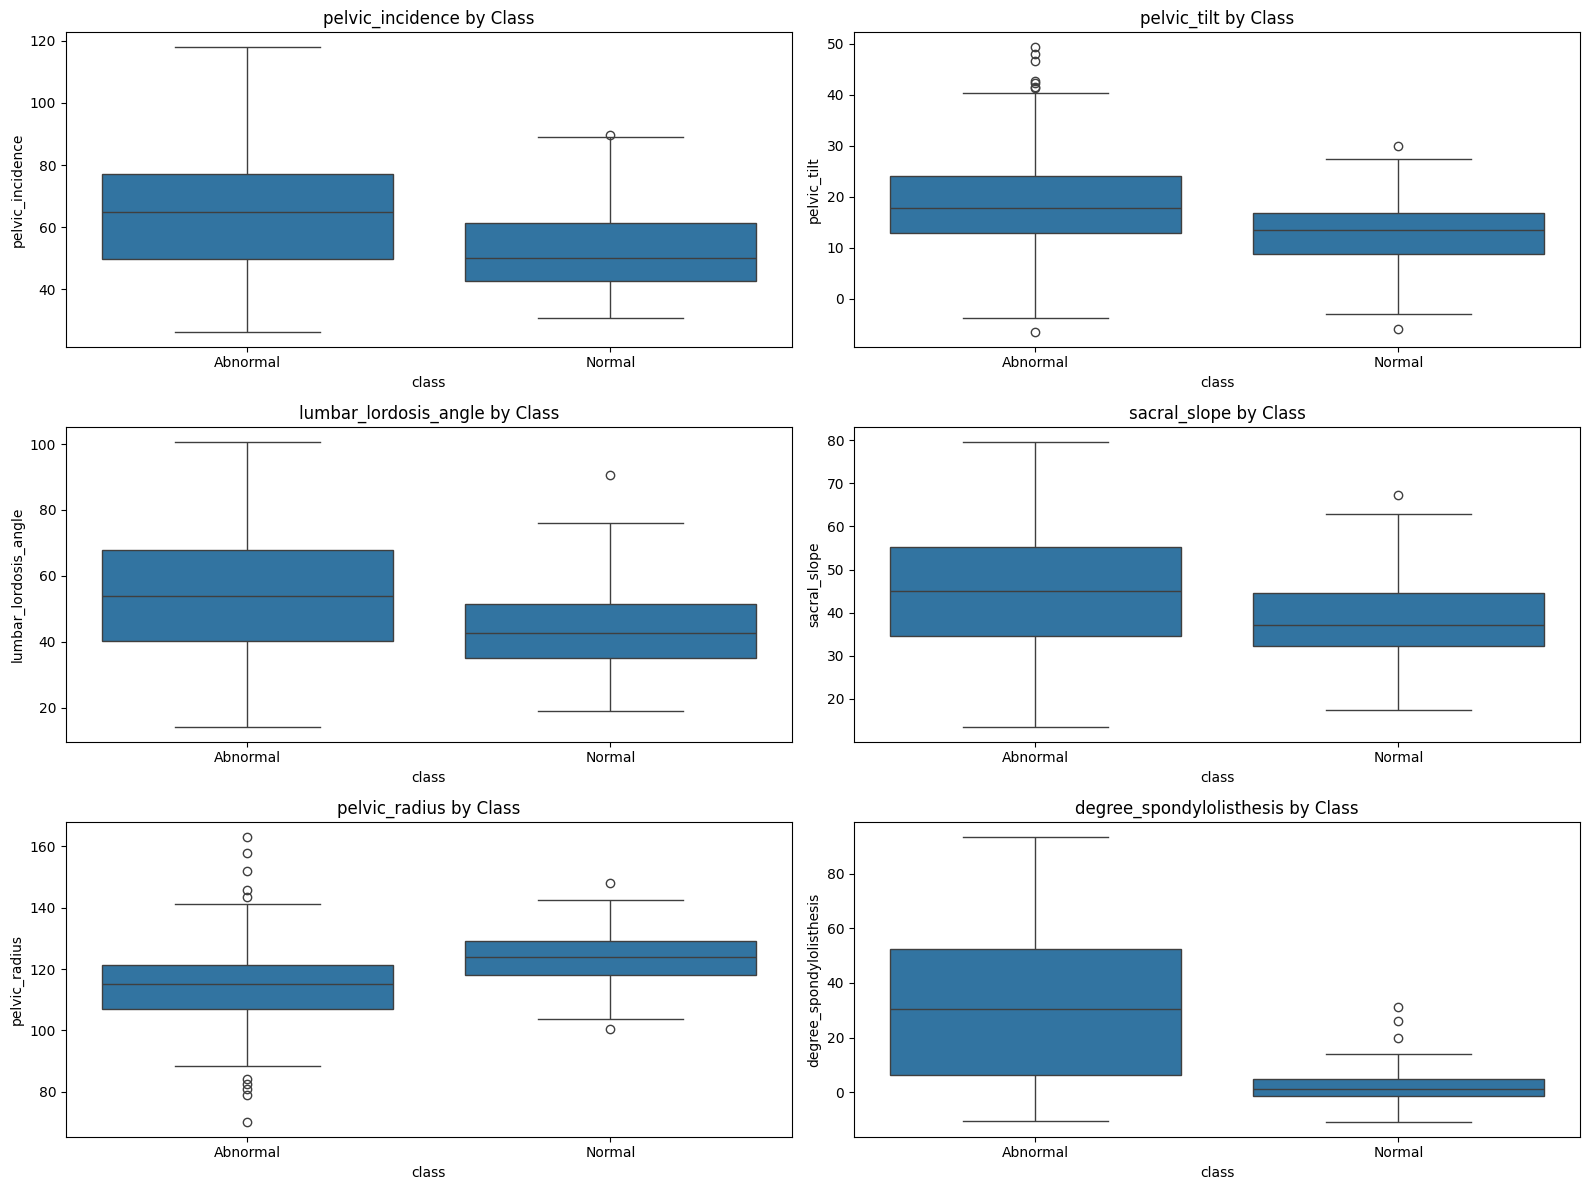

In [8]:
# Box plots for each feature by class in a grid layout
n_rows = len(features) // 2 + len(features) % 2
n_cols = 2

# Create the figure and axes for the grid
fig, axes = plt.subplots(
    n_rows, n_cols, figsize=(16, 4 * n_rows)
)  # Adjust height as needed

# Plot box plots for each feature
for idx, feature in enumerate(features):
    row = idx // n_cols
    col = idx % n_cols
    ax = axes[row, col]
    sns.boxplot(x="class", y=feature, data=df_binary, ax=ax)
    ax.set_title(f"{feature} by Class")

# Remove empty subplots if the number of features isn't even
if len(features) % 2 != 0:
    fig.delaxes(axes[-1, -1])

plt.tight_layout()
plt.show()

### 5. Pairplots


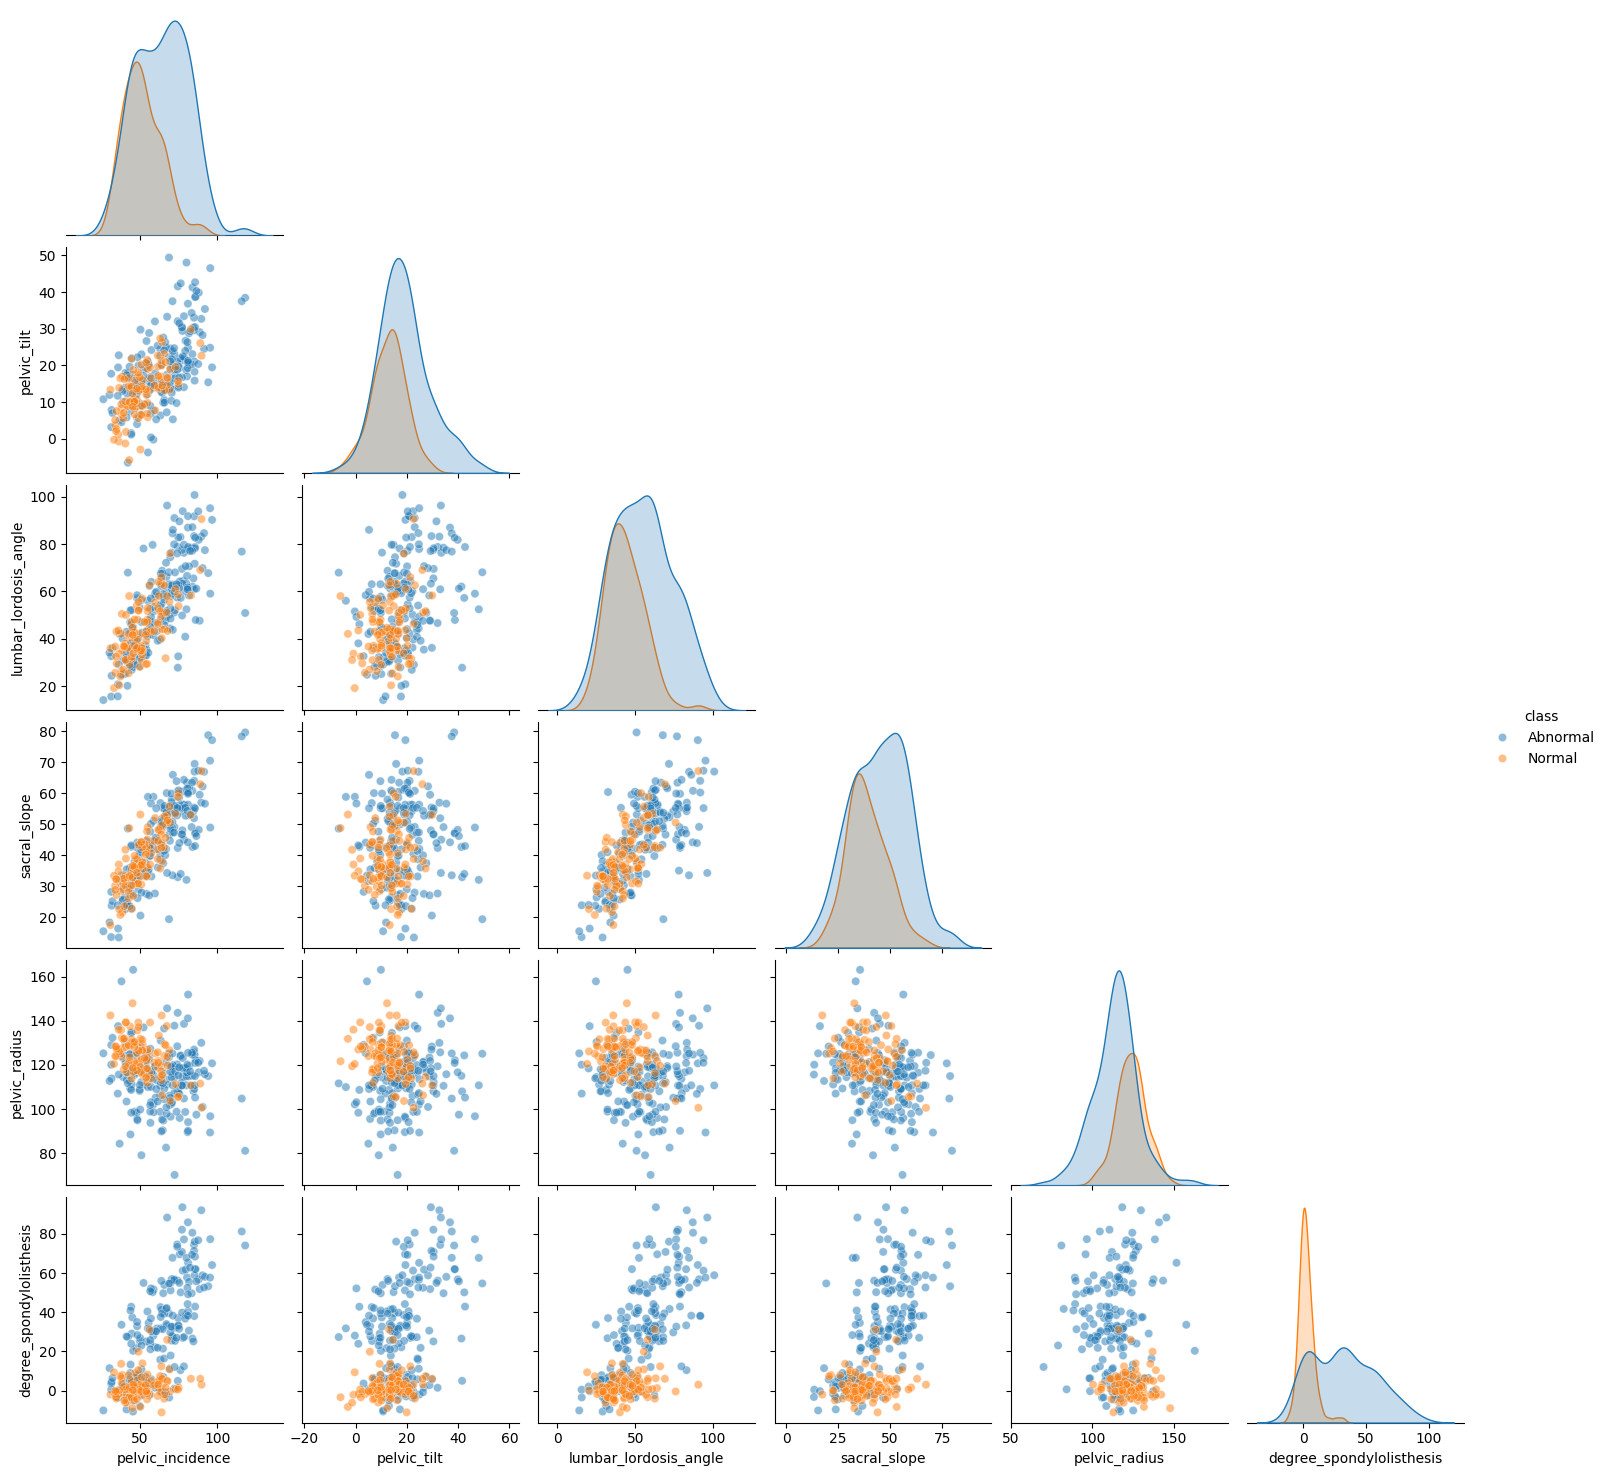

In [9]:
sns.pairplot(
    df_binary, hue="class", vars=features, plot_kws={"alpha": 0.5}, corner=True
)

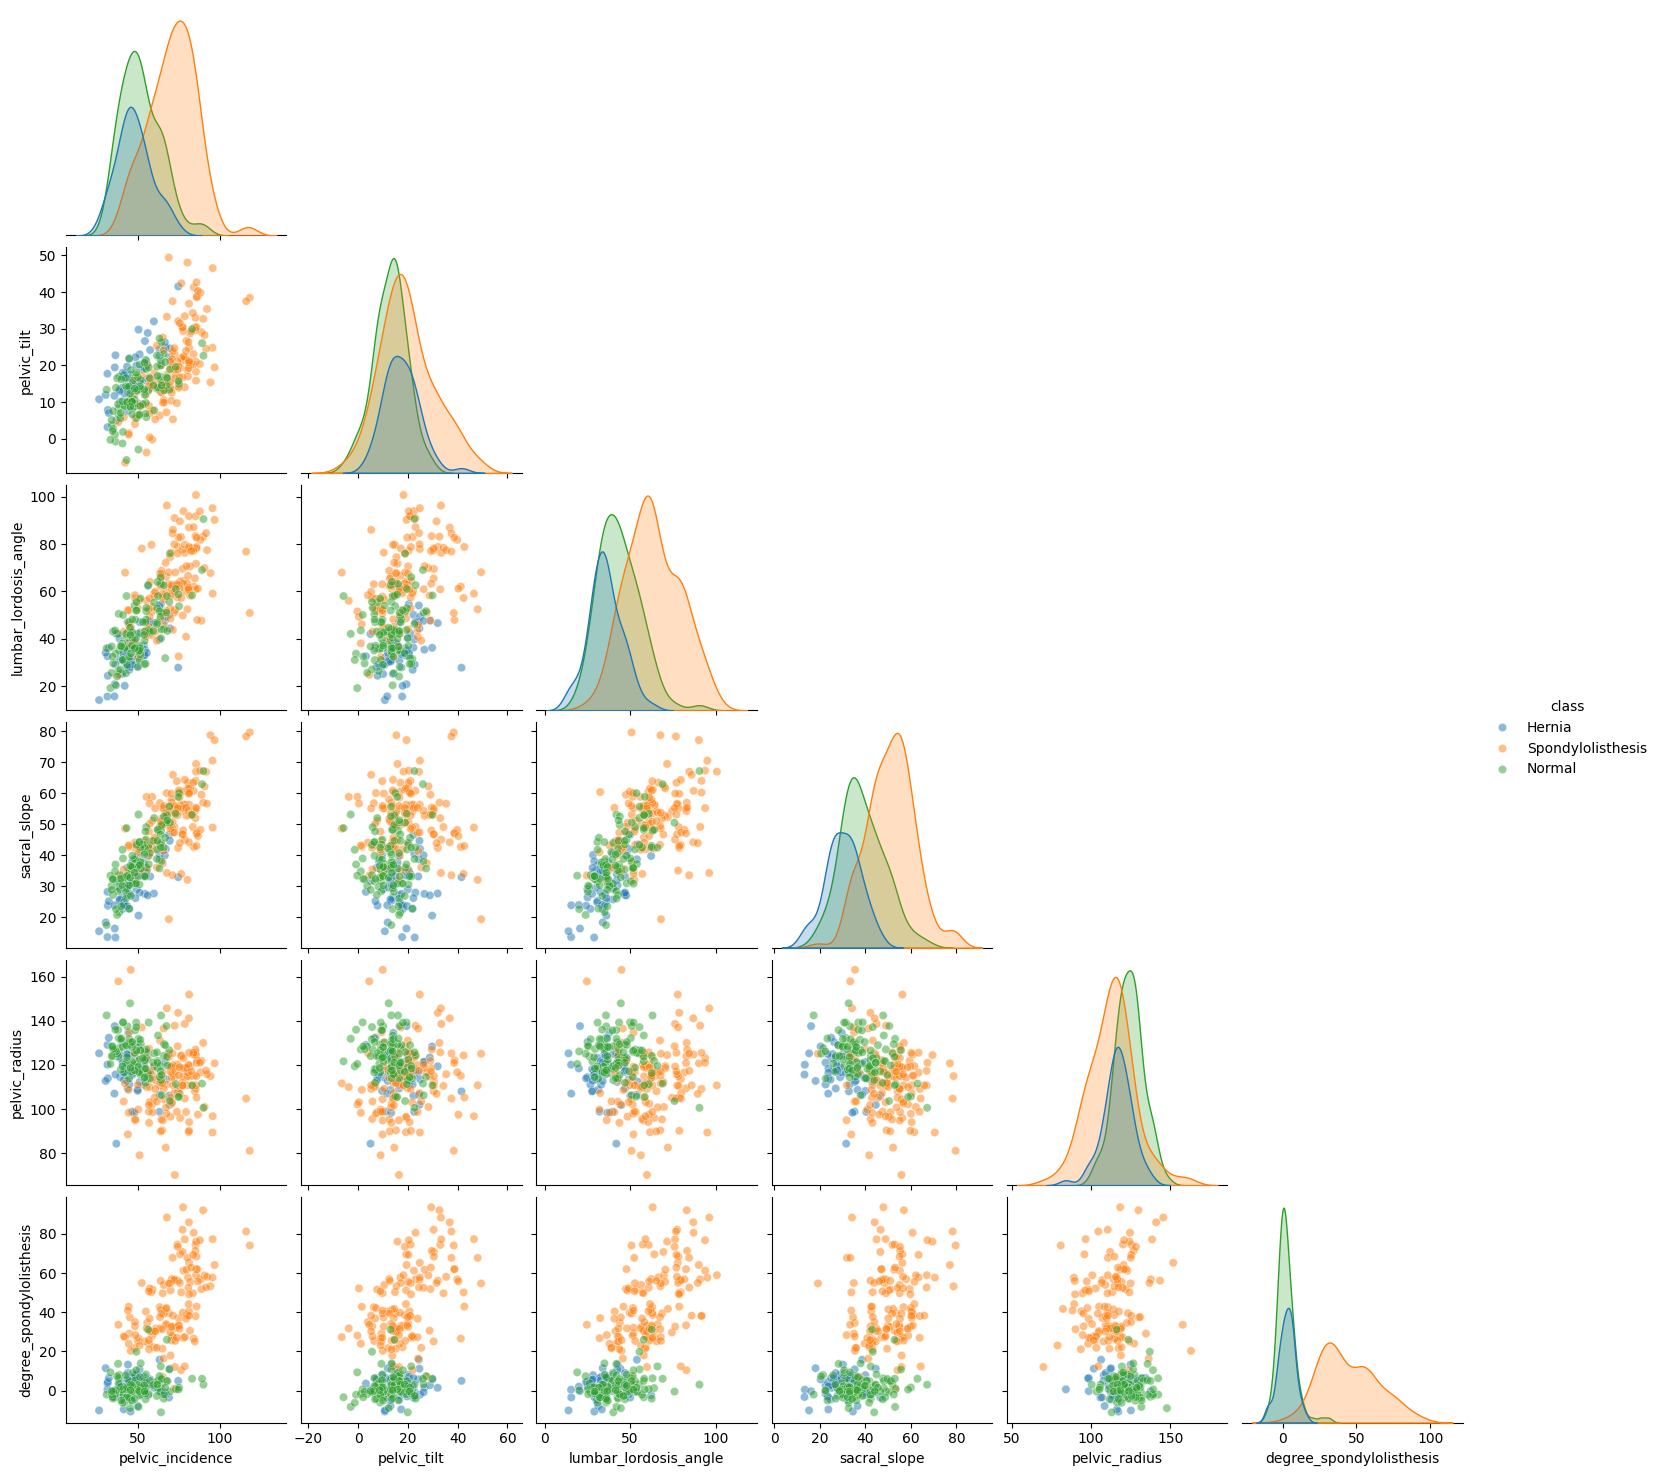

In [10]:
sns.pairplot(df, hue="class", vars=features, plot_kws={"alpha": 0.5}, corner=True)

## rule based model


In [11]:
df_binary["rule_based_class"] = "Normal"

df_binary.loc[
    ~(
        df_binary["pelvic_incidence"].between(43, 62, inclusive="both")
        & df_binary["pelvic_tilt"].between(7, 19, inclusive="both")
        & df_binary["lumbar_lordosis_angle"].between(52, 75, inclusive="both")
        & df_binary["sacral_slope"].between(32, 49, inclusive="both")
        & df_binary["pelvic_radius"].between(107, 139, inclusive="both")
    ),
    "rule_based_class",
] = "Abnormal"

In [12]:
df_binary["rule_based_class"].value_counts()

rule_based_class
Abnormal    292
Normal        7
Name: count, dtype: int64

## ML Setup


In [13]:
## imports and configs
from sklearn.model_selection import cross_validate, StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from copy import deepcopy

BINARY_SCORING: dict[str, str] = {
    "accuracy": "accuracy",
    "f1_weighted": "f1_weighted",
    "roc_auc": "roc_auc",
}
MULTI_CLASS_SCORING: dict[str, str] = {
    "accuracy": "accuracy",
    "f1_weighted": "f1_weighted",
    "roc_auc": "roc_auc_ovr",
}
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=SEED)
lr_model_binary_pipeline = Pipeline(
    [("scaler", StandardScaler()), ("logreg", LogisticRegression(random_state=SEED))],
)
lr_model_hernia_pipeline = deepcopy(lr_model_binary_pipeline)
lr_model_spondy_pipeline = deepcopy(lr_model_binary_pipeline)


# multi class is the exact same as binary pipeline
# by default multi_class = 'auto' which selects the multinomial logistic regression for us
lr_model_multi_class_pipeline = Pipeline(
    [
        ("scaler", StandardScaler()),
        ("logreg", LogisticRegression(random_state=SEED)),
    ],
)

In [14]:
from extended_pipeline import ExtendedPipeline
import numpy as np

## Binary Logistic Regression


In [15]:
def false_negative_rate(cm: np.ndarray) -> dict:
    """
    Compute False Negative Rate (FNR) for each class in a multi-class confusion matrix.
    
    Args:
        cm (np.ndarray): Confusion matrix (square matrix).
    
    Returns:
        dict: False Negative Rate for each class.
    """
    fnr = {}
    num_classes = cm.shape[0]  # Number of classes
    for i in range(num_classes):
        FN = sum(cm[i, :]) - cm[i, i]  # False Negatives for class i
        TP = cm[i, i]                 # True Positives for class i
        fnr[i] = FN / (FN + TP) if (FN + TP) > 0 else 0  # Avoid division by zero
    return fnr

Cross-validation results:
accuracy (train): 0.8521 ± 0.0101
accuracy (test): 0.8463 ± 0.0615
f1_weighted (train): 0.8527 ± 0.0100
f1_weighted (test): 0.8457 ± 0.0626
roc_auc (train): 0.9383 ± 0.0045
roc_auc (test): 0.9294 ± 0.0409

Final Model Performance on Test Data:
Accuracy: 0.8167
F1 Score: 0.8213
False Negative Rate (FNR): 0.1591
ROC AUC Score: 0.8608
              precision    recall  f1-score   support

    Abnormal       0.90      0.84      0.87        44
      Normal       0.63      0.75      0.69        16

    accuracy                           0.82        60
   macro avg       0.77      0.80      0.78        60
weighted avg       0.83      0.82      0.82        60



Text(0.5, 1.0, 'Normal v Abnormal — all features')

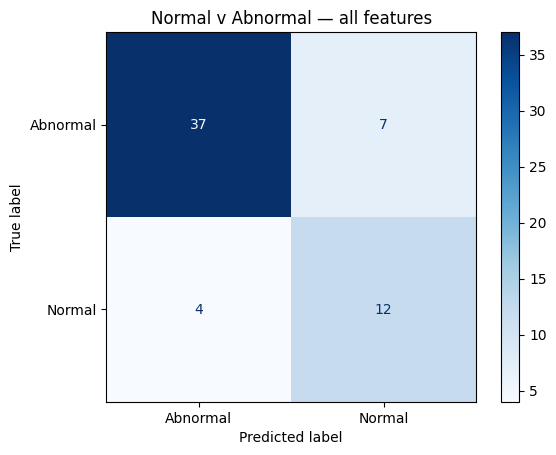

In [16]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    classification_report,
    accuracy_score,
    f1_score,
    roc_auc_score,
    confusion_matrix,
    ConfusionMatrixDisplay,
)

X_binary = df_binary.drop(columns=["class", "rule_based_class"], errors="ignore")
y_binary = df_binary["class"]

X_binary_train: pd.DataFrame
X_binary_test: pd.DataFrame
y_binary_train: np.ndarray
y_binary_test: np.ndarray
X_binary_train, X_binary_test, y_binary_train, y_binary_test = train_test_split(
    X_binary, y_binary.values.ravel(), test_size=TEST_SIZE, random_state=SEED
)

# Cross-validation scores
lr_binary_cv_results: dict[str, np.ndarray] = cross_validate(
    lr_model_binary_pipeline,
    X_binary,
    y_binary,
    cv=cv,
    scoring=BINARY_SCORING,
    return_train_score=True,
    n_jobs=-1,
)

# Results
print("Cross-validation results:")
for metric in BINARY_SCORING.keys():
    print(
        f"{metric} (train): {lr_binary_cv_results[f'train_{metric}'].mean():.4f} ± {lr_binary_cv_results[f'train_{metric}'].std():.4f}"
    )
    print(
        f"{metric} (test): {lr_binary_cv_results[f'test_{metric}'].mean():.4f} ± {lr_binary_cv_results[f'test_{metric}'].std():.4f}"
    )

# Final Model Training and Evaluation
lr_model_binary_pipeline.fit(X_binary_train, y_binary_train)
y_binary_pred = lr_model_binary_pipeline.predict(X_binary_test)
y_binary_prob = lr_model_binary_pipeline.predict_proba(X_binary_test)[:, 1]

print("\nFinal Model Performance on Test Data:")
print(f"Accuracy: {accuracy_score(y_binary_test, y_binary_pred):.4f}")
print(f'F1 Score: {f1_score(y_binary_test, y_binary_pred, average="weighted"):.4f}')
print(f"False Negative Rate (FNR): {false_negative_rate(confusion_matrix(y_binary_test, y_binary_pred))[0]:.4f}")
print(f"ROC AUC Score: {roc_auc_score(y_binary_test, y_binary_prob):.4f}")
print(classification_report(y_binary_test, y_binary_pred))
ConfusionMatrixDisplay(
    confusion_matrix=confusion_matrix(y_binary_test, y_binary_pred),
    display_labels=lr_model_binary_pipeline.classes_,
).plot(cmap=CMAP)
plt.title("Normal v Abnormal — all features")

## Multiclass Logistic Regression


Cross-validation results:
accuracy (train): 0.8655 ± 0.0085
accuracy (test): 0.8594 ± 0.0536
f1_weighted (train): 0.8651 ± 0.0086
f1_weighted (test): 0.8571 ± 0.0547
roc_auc (train): 0.9650 ± 0.0017
roc_auc (test): 0.9584 ± 0.0136

Final Model Performance on Test Data:
Accuracy: 0.7833
F1 Score: 0.7826
Hernia False Negative Rate (FNR): 0.5000
Normal False Negative Rate (FNR): 0.2500
Spondy False Negative Rate (FNR): 0.0938
ROC AUC Score: 0.9280
                   precision    recall  f1-score   support

           Hernia       0.86      0.50      0.63        12
           Normal       0.57      0.75      0.65        16
Spondylolisthesis       0.91      0.91      0.91        32

         accuracy                           0.78        60
        macro avg       0.78      0.72      0.73        60
     weighted avg       0.81      0.78      0.78        60



Text(0.5, 1.0, 'Multiclass — all features')

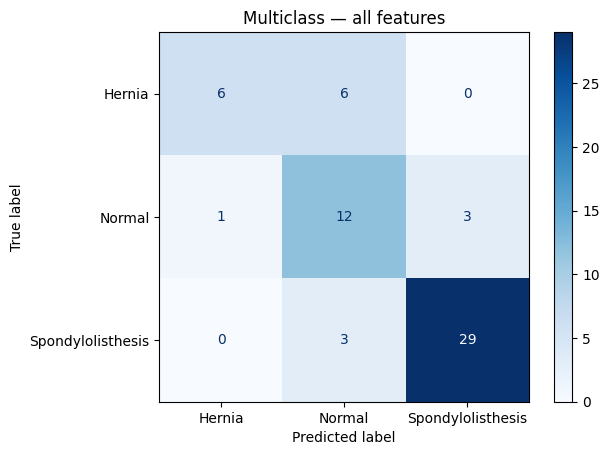

In [17]:
X_multi_class = df.drop(columns="class")
y_multi_class = df["class"]

X_multi_class_train: pd.DataFrame
X_multi_class_test: pd.DataFrame
y_multi_class_train: np.ndarray
y_multi_class_test: np.ndarray
X_multi_class_train, X_multi_class_test, y_multi_class_train, y_multi_class_test = (
    train_test_split(
        X_multi_class,
        y_multi_class.values.ravel(),
        test_size=TEST_SIZE,
        random_state=SEED,
    )
)

# Cross-validation scores
lr_multi_class_cv_results: dict[str, np.ndarray] = cross_validate(
    lr_model_multi_class_pipeline,
    X_multi_class,
    y_multi_class,
    cv=cv,
    scoring=MULTI_CLASS_SCORING,
    return_train_score=True,
    n_jobs=-1,
)

# Results
print("Cross-validation results:")
for metric in MULTI_CLASS_SCORING.keys():
    print(
        f"{metric} (train): {lr_multi_class_cv_results[f'train_{metric}'].mean():.4f} ± {lr_multi_class_cv_results[f'train_{metric}'].std():.4f}"
    )
    print(
        f"{metric} (test): {lr_multi_class_cv_results[f'test_{metric}'].mean():.4f} ± {lr_multi_class_cv_results[f'test_{metric}'].std():.4f}"
    )

# Final Model Training and Evaluation
lr_model_multi_class_pipeline.fit(X_multi_class_train, y_multi_class_train)
y_multi_class_pred = lr_model_multi_class_pipeline.predict(X_multi_class_test)
y_multi_class_prob = lr_model_multi_class_pipeline.predict_proba(X_multi_class_test)

print("\nFinal Model Performance on Test Data:")
print(f"Accuracy: {accuracy_score(y_multi_class_test, y_multi_class_pred):.4f}")
print(
    f'F1 Score: {f1_score(y_multi_class_test, y_multi_class_pred, average="weighted"):.4f}'
)
print(f"Hernia False Negative Rate (FNR): {false_negative_rate(confusion_matrix(y_multi_class_test, y_multi_class_pred))[0]:.4f}")
print(f"Normal False Negative Rate (FNR): {false_negative_rate(confusion_matrix(y_multi_class_test, y_multi_class_pred))[1]:.4f}")
print(f"Spondy False Negative Rate (FNR): {false_negative_rate(confusion_matrix(y_multi_class_test, y_multi_class_pred))[2]:.4f}")
print(
    f"ROC AUC Score: {roc_auc_score(y_multi_class_test, y_multi_class_prob, multi_class='ovr'):.4f}"
)
print(classification_report(y_multi_class_test, y_multi_class_pred))
ConfusionMatrixDisplay(
    confusion_matrix=confusion_matrix(y_multi_class_test, y_multi_class_pred),
    display_labels=lr_model_multi_class_pipeline.classes_,
).plot(cmap=CMAP)
plt.title("Multiclass — all features")

## Feature Selection


In [18]:
from sklearn.feature_selection import RFECV
from sklearn.model_selection import StratifiedKFold


def plot_rfecv_chart(rfecv: RFECV) -> None:
    """source: https://scikit-learn.org/stable/auto_examples/feature_selection/plot_rfe_with_cross_validation.html"""
    cv_results = pd.DataFrame(rfecv.cv_results_)
    plt.figure()
    plt.xlabel("Number of features selected")
    plt.ylabel("Mean test accuracy")
    plt.errorbar(
        x=cv_results["n_features"],
        y=cv_results["mean_test_score"],
        yerr=cv_results["std_test_score"],
    )
    plt.title("Recursive Feature Elimination \nwith correlated features")
    plt.show()
    return None


def rfe_pipeline_with_rfecv(
    X_train: pd.DataFrame,
    y_train: np.ndarray,
    *,
    pipeline: Pipeline,
    estimator_name: str = "logreg",
    scoring: str = "f1_weighted",
    n_splits: int = 10,
    seed: int = SEED,
    plot: bool = True,
) -> list[str]:
    """
    Perform RFECV on a pipeline with preprocessing and feature selection.

    Args:
        X_train (pd.DataFrame): Training features.
        y_train (np.ndarray): Training labels.
        pipeline (Pipeline): Pipeline with preprocessing and model.
        estimator_name (str): Name of the estimator step in the pipeline.
        scoring (str): Scoring metric for RFECV.
        n_splits (int): Number of CV splits.
        plot (bool): Plot the feature v scoring chart

    Returns:
        list[str]: Best features selected by RFECV.
    """
    # Wrap the pipeline with the specified estimator name
    wrapped_pipeline = ExtendedPipeline(pipeline, estimator_name=estimator_name)

    cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=seed)
    rfecv = RFECV(estimator=wrapped_pipeline, cv=cv, scoring=scoring)
    rfecv.fit(X_train, y_train)

    print(f"Optimal number of features: {rfecv.n_features_}")
    if plot:
        plot_rfecv_chart(rfecv)
    return X_train.columns[rfecv.support_].tolist()

Optimal number of features: 4


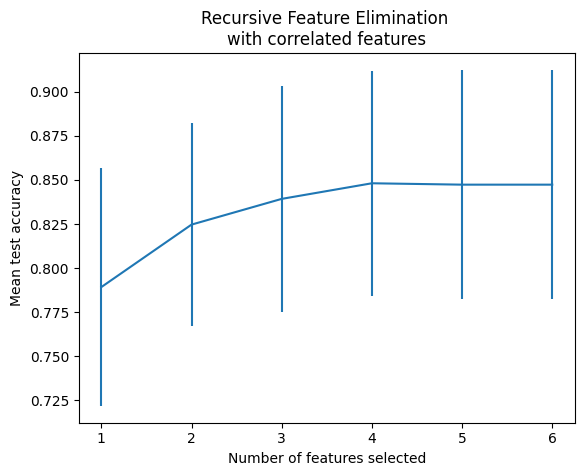

['pelvic_tilt', 'sacral_slope', 'pelvic_radius', 'degree_spondylolisthesis']

In [19]:
rfe_pipeline_with_rfecv(
    X_binary_train, y_binary_train, pipeline=lr_model_binary_pipeline
)

Cross-validation results:
accuracy (train): 0.8554 ± 0.0075
accuracy (test): 0.8464 ± 0.0578
f1_weighted (train): 0.8562 ± 0.0073
f1_weighted (test): 0.8474 ± 0.0568
roc_auc (train): 0.9382 ± 0.0045
roc_auc (test): 0.9299 ± 0.0389

Final Model Performance on Test Data:
Accuracy: 0.8000
F1 Score: 0.8036
False Negative Rate (FNR): 0.1591
ROC AUC Score: 0.8608
              precision    recall  f1-score   support

    Abnormal       0.88      0.84      0.86        44
      Normal       0.61      0.69      0.65        16

    accuracy                           0.80        60
   macro avg       0.75      0.76      0.75        60
weighted avg       0.81      0.80      0.80        60



Text(0.5, 1.0, 'Normal v Abnormal — four features')

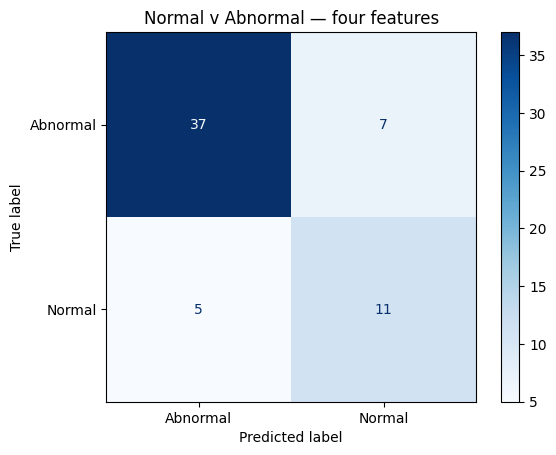

In [20]:
X_binary_rfe = X_binary[
    ["pelvic_tilt", "sacral_slope", "pelvic_radius", "degree_spondylolisthesis"]
]
X_binary_rfe_train: pd.DataFrame
X_binary_rfe_test: pd.DataFrame
y_binary_rfe_train: pd.DataFrame
y_binary_rfe_test: pd.DataFrame
X_binary_rfe_train, X_binary_rfe_test, y_binary_rfe_train, y_binary_rfe_test = (
    train_test_split(
        X_binary_rfe, y_binary.values.ravel(), test_size=TEST_SIZE, random_state=SEED
    )
)

# Cross-validation scores
lr_binary_feature_selection_cv_results = cross_validate(
    lr_model_binary_pipeline,
    X_binary_rfe,
    y_binary,
    cv=cv,
    scoring=BINARY_SCORING,
    return_train_score=True,
    n_jobs=-1,
)

# Results
print("Cross-validation results:")
for metric in BINARY_SCORING.keys():
    print(
        f"{metric} (train): {lr_binary_feature_selection_cv_results[f'train_{metric}'].mean():.4f} ± {lr_binary_feature_selection_cv_results[f'train_{metric}'].std():.4f}"
    )
    print(
        f"{metric} (test): {lr_binary_feature_selection_cv_results[f'test_{metric}'].mean():.4f} ± {lr_binary_feature_selection_cv_results[f'test_{metric}'].std():.4f}"
    )

# Final Model Training and Evaluation
lr_model_binary_pipeline.fit(X_binary_rfe_train, y_binary_rfe_train)
y_binary_rfe_pred = lr_model_binary_pipeline.predict(X_binary_rfe_test)
y_binary_rfe_prob = lr_model_binary_pipeline.predict_proba(X_binary_rfe_test)[:, 1]

print("\nFinal Model Performance on Test Data:")
print(f"Accuracy: {accuracy_score(y_binary_rfe_test, y_binary_rfe_pred):.4f}")
print(
    f'F1 Score: {f1_score(y_binary_rfe_test, y_binary_rfe_pred, average="weighted"):.4f}'
)
print(f"False Negative Rate (FNR): {false_negative_rate(confusion_matrix(y_binary_rfe_test, y_binary_rfe_pred))[0]:.4f}")
print(f"ROC AUC Score: {roc_auc_score(y_binary_rfe_test, y_binary_rfe_prob):.4f}")
print(classification_report(y_binary_rfe_test, y_binary_rfe_pred))
ConfusionMatrixDisplay(
    confusion_matrix=confusion_matrix(y_binary_rfe_test, y_binary_rfe_pred),
    display_labels=lr_model_binary_pipeline.classes_,
).plot(cmap=CMAP)
plt.title("Normal v Abnormal — four features")

Optimal number of features: 3


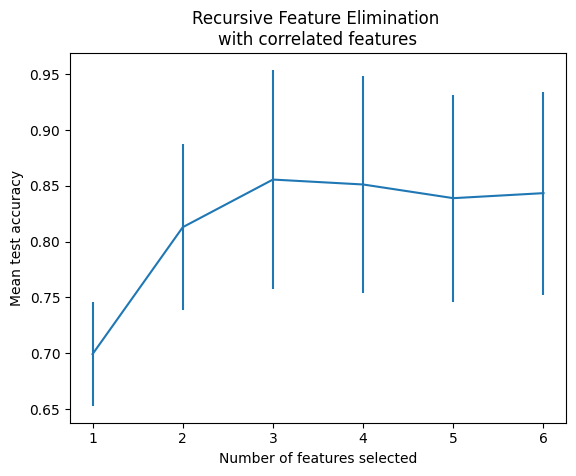

['sacral_slope', 'pelvic_radius', 'degree_spondylolisthesis']

In [21]:
rfe_pipeline_with_rfecv(
    X_multi_class_train, y_multi_class_train, pipeline=lr_model_multi_class_pipeline
)

Cross-validation results:
accuracy (train): 0.8658 ± 0.0061
accuracy (test): 0.8629 ± 0.0348
f1_weighted (train): 0.8648 ± 0.0062
f1_weighted (test): 0.8601 ± 0.0329
roc_auc (train): 0.9606 ± 0.0019
roc_auc (test): 0.9558 ± 0.0164

Final Model Performance on Test Data:
Accuracy: 0.8167
F1 Score: 0.8184
Hernia False Negative Rate (FNR): 0.4167
Normal False Negative Rate (FNR): 0.1875
Spondy False Negative Rate (FNR): 0.0938
ROC AUC Score: 0.9338
                   precision    recall  f1-score   support

           Hernia       0.88      0.58      0.70        12
           Normal       0.62      0.81      0.70        16
Spondylolisthesis       0.94      0.91      0.92        32

         accuracy                           0.82        60
        macro avg       0.81      0.77      0.77        60
     weighted avg       0.84      0.82      0.82        60



Text(0.5, 1.0, 'Multiclass — three features')

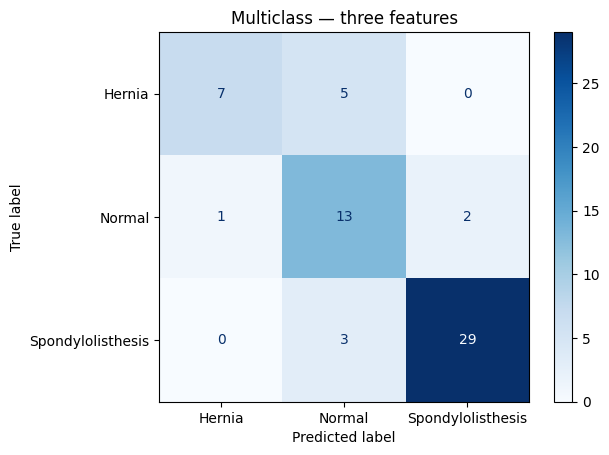

In [22]:
X_multi_class_rfe = X_multi_class[
    ["sacral_slope", "pelvic_radius", "degree_spondylolisthesis"]
]

X_multi_class_rfe_train: pd.DataFrame
X_multi_class_rfe_test: pd.DataFrame
y_multi_class_rfe_train: np.ndarray
y_multi_class_rfe_test: np.ndarray

(
    X_multi_class_rfe_train,
    X_multi_class_rfe_test,
    y_multi_class_rfe_train,
    y_multi_class_rfe_test,
) = train_test_split(
    X_multi_class_rfe,
    y_multi_class.values.ravel(),
    test_size=TEST_SIZE,
    random_state=SEED,
)


# Cross-validation scores
lr_multi_class_feature_selection_cv_results = cross_validate(
    lr_model_multi_class_pipeline,
    X_multi_class_rfe,
    y_multi_class,
    cv=cv,
    scoring=MULTI_CLASS_SCORING,
    return_train_score=True,
    n_jobs=-1,
)

# Results
print("Cross-validation results:")
for metric in MULTI_CLASS_SCORING.keys():
    print(
        f"{metric} (train): {lr_multi_class_feature_selection_cv_results[f'train_{metric}'].mean():.4f} ± {lr_multi_class_feature_selection_cv_results[f'train_{metric}'].std():.4f}"
    )
    print(
        f"{metric} (test): {lr_multi_class_feature_selection_cv_results[f'test_{metric}'].mean():.4f} ± {lr_multi_class_feature_selection_cv_results[f'test_{metric}'].std():.4f}"
    )

# Final Model Training and Evaluation
lr_model_multi_class_pipeline.fit(X_multi_class_rfe_train, y_multi_class_rfe_train)
y_multi_class_rfe_pred = lr_model_multi_class_pipeline.predict(X_multi_class_rfe_test)
y_multi_class_rfe_prob = lr_model_multi_class_pipeline.predict_proba(
    X_multi_class_rfe_test
)

print("\nFinal Model Performance on Test Data:")
print(f"Accuracy: {accuracy_score(y_multi_class_rfe_test, y_multi_class_rfe_pred):.4f}")
print(
    f'F1 Score: {f1_score(y_multi_class_rfe_test, y_multi_class_rfe_pred, average="weighted"):.4f}'
)
print(f"Hernia False Negative Rate (FNR): {false_negative_rate(confusion_matrix(y_multi_class_rfe_test, y_multi_class_rfe_pred))[0]:.4f}")
print(f"Normal False Negative Rate (FNR): {false_negative_rate(confusion_matrix(y_multi_class_rfe_test, y_multi_class_rfe_pred))[1]:.4f}")
print(f"Spondy False Negative Rate (FNR): {false_negative_rate(confusion_matrix(y_multi_class_rfe_test, y_multi_class_rfe_pred))[2]:.4f}")
print(
    f"ROC AUC Score: {roc_auc_score(y_multi_class_rfe_test, y_multi_class_rfe_prob, multi_class='ovr'):.4f}"
)
print(classification_report(y_multi_class_rfe_test, y_multi_class_rfe_pred))
ConfusionMatrixDisplay(
    confusion_matrix=confusion_matrix(y_multi_class_rfe_test, y_multi_class_rfe_pred),
    display_labels=lr_model_multi_class_pipeline.classes_,
).plot(cmap=CMAP)
plt.title("Multiclass — three features")

In [23]:
multi_class_predictions_proba = pd.DataFrame(
    lr_model_multi_class_pipeline.predict_proba(X_multi_class_rfe_test),
    columns=lr_model_multi_class_pipeline.classes_,
)
multi_class_predictions = pd.DataFrame(
    lr_model_multi_class_pipeline.predict(X_multi_class_rfe_test),
    columns=["prediction"],
)
multi_class_proba_df = pd.concat(
    [multi_class_predictions_proba, multi_class_predictions], axis=1
)
multi_class_proba_df["class"] = pd.DataFrame(y_multi_class_test)

## Normal v Hernia logistic regression model


Cross-validation results:
accuracy (train): 0.8104 ± 0.0116
accuracy (test): 0.7937 ± 0.0742
f1_weighted (train): 0.8085 ± 0.0119
f1_weighted (test): 0.7872 ± 0.0775
roc_auc (train): 0.9009 ± 0.0069
roc_auc (test): 0.8917 ± 0.0743

Final Model Performance on Test Data:
Accuracy: 0.8125
F1 Score: 0.8125
False Negative Rate (FNR): 0.2308
ROC AUC Score: 0.9028
              precision    recall  f1-score   support

      Hernia       0.77      0.77      0.77        13
      Normal       0.84      0.84      0.84        19

    accuracy                           0.81        32
   macro avg       0.81      0.81      0.81        32
weighted avg       0.81      0.81      0.81        32



Text(0.5, 1.0, 'Normal v Hernia — all features')

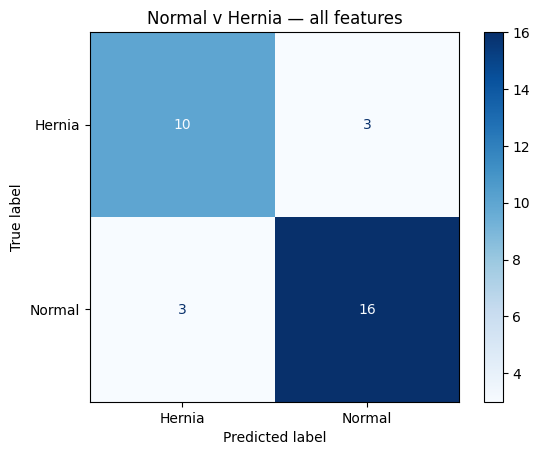

In [24]:
X_hernia = df.query('`class` != "Spondylolisthesis"').drop(columns="class")
y_hernia = df.query('`class` != "Spondylolisthesis"')["class"]

X_hernia_train: pd.DataFrame
X_hernia_test: pd.DataFrame
y_hernia_train: np.ndarray
y_hernia_test: np.ndarray

X_hernia_train, X_hernia_test, y_hernia_train, y_hernia_test = train_test_split(
    X_hernia, y_hernia.values.ravel(), test_size=TEST_SIZE, random_state=SEED
)

# Cross-validation scores
lr_hernia_cv_results: dict[str, np.ndarray] = cross_validate(
    lr_model_hernia_pipeline,
    X_hernia,
    y_hernia,
    cv=cv,
    scoring=BINARY_SCORING,
    return_train_score=True,
    n_jobs=-1,
)

# Results
print("Cross-validation results:")
for metric in BINARY_SCORING.keys():
    print(
        f"{metric} (train): {lr_hernia_cv_results[f'train_{metric}'].mean():.4f} ± {lr_hernia_cv_results[f'train_{metric}'].std():.4f}"
    )
    print(
        f"{metric} (test): {lr_hernia_cv_results[f'test_{metric}'].mean():.4f} ± {lr_hernia_cv_results[f'test_{metric}'].std():.4f}"
    )

# Final Model Training and Evaluation
lr_model_hernia_pipeline.fit(X_hernia_train, y_hernia_train)
y_hernia_pred = lr_model_hernia_pipeline.predict(X_hernia_test)
y_hernia_prob = lr_model_hernia_pipeline.predict_proba(X_hernia_test)[:, 1]

print("\nFinal Model Performance on Test Data:")
print(f"Accuracy: {accuracy_score(y_hernia_test, y_hernia_pred):.4f}")
print(f'F1 Score: {f1_score(y_hernia_test, y_hernia_pred, average="weighted"):.4f}')
print(f"False Negative Rate (FNR): {false_negative_rate(confusion_matrix(y_hernia_test, y_hernia_pred))[0]:.4f}")
print(f"ROC AUC Score: {roc_auc_score(y_hernia_test, y_hernia_prob):.4f}")
print(classification_report(y_hernia_test, y_hernia_pred))
ConfusionMatrixDisplay(
    confusion_matrix=confusion_matrix(y_hernia_test, y_hernia_pred),
    display_labels=lr_model_hernia_pipeline.classes_,
).plot(cmap=CMAP)
plt.title("Normal v Hernia — all features")

Optimal number of features: 4


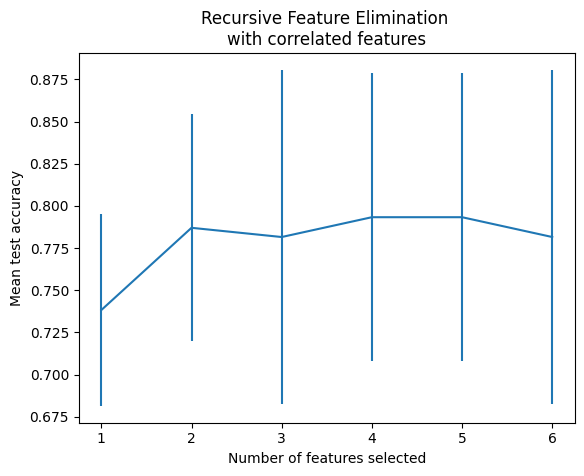

['pelvic_tilt', 'lumbar_lordosis_angle', 'sacral_slope', 'pelvic_radius']

In [25]:
rfe_pipeline_with_rfecv(
    X_hernia_train, y_hernia_train, pipeline=lr_model_binary_pipeline
)

Cross-validation results:
accuracy (train): 0.8125 ± 0.0108
accuracy (test): 0.8000 ± 0.0781
f1_weighted (train): 0.8107 ± 0.0109
f1_weighted (test): 0.7947 ± 0.0812
roc_auc (train): 0.8996 ± 0.0066
roc_auc (test): 0.8950 ± 0.0683

Final Model Performance on Test Data:
Accuracy: 0.7812
F1 Score: 0.7797
False Negative Rate (FNR): 0.3077
ROC AUC Score: 0.9069
              precision    recall  f1-score   support

      Hernia       0.75      0.69      0.72        13
      Normal       0.80      0.84      0.82        19

    accuracy                           0.78        32
   macro avg       0.78      0.77      0.77        32
weighted avg       0.78      0.78      0.78        32



Text(0.5, 1.0, 'Normal v Hernia — four features')

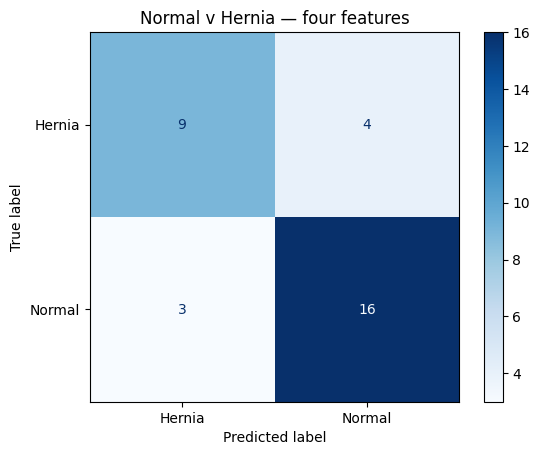

In [26]:
X_hernia_rfe = X_hernia[
    ["pelvic_tilt", "lumbar_lordosis_angle", "sacral_slope", "pelvic_radius"]
]

X_hernia_rfe_train: pd.DataFrame
X_hernia_rfe_test: pd.DataFrame
y_hernia_rfe_train: np.ndarray
y_hernia_rfe_test: np.ndarray
X_hernia_rfe_train, X_hernia_rfe_test, y_hernia_rfe_train, y_hernia_rfe_test = (
    train_test_split(
        X_hernia_rfe, y_hernia.values.ravel(), test_size=TEST_SIZE, random_state=SEED
    )
)

# Cross-validation scores
lr_hernia_feature_selection_cv_results = cross_validate(
    lr_model_hernia_pipeline,
    X_hernia_rfe,
    y_hernia,
    cv=cv,
    scoring=BINARY_SCORING,
    return_train_score=True,
    n_jobs=-1,
)

# Results
print("Cross-validation results:")
for metric in BINARY_SCORING.keys():
    print(
        f"{metric} (train): {lr_hernia_feature_selection_cv_results[f'train_{metric}'].mean():.4f} ± {lr_hernia_feature_selection_cv_results[f'train_{metric}'].std():.4f}"
    )
    print(
        f"{metric} (test): {lr_hernia_feature_selection_cv_results[f'test_{metric}'].mean():.4f} ± {lr_hernia_feature_selection_cv_results[f'test_{metric}'].std():.4f}"
    )

# Final Model Training and Evaluation
lr_model_hernia_pipeline.fit(X_hernia_rfe_train, y_hernia_rfe_train)
y_hernia_rfe_pred = lr_model_hernia_pipeline.predict(X_hernia_rfe_test)
y_hernia_rfe_prob = lr_model_hernia_pipeline.predict_proba(X_hernia_rfe_test)[:, 1]

print("\nFinal Model Performance on Test Data:")
print(f"Accuracy: {accuracy_score(y_hernia_rfe_test, y_hernia_rfe_pred):.4f}")
print(
    f'F1 Score: {f1_score(y_hernia_rfe_test, y_hernia_rfe_pred, average="weighted"):.4f}'
)
print(f"False Negative Rate (FNR): {false_negative_rate(confusion_matrix(y_hernia_rfe_test, y_hernia_rfe_pred))[0]:.4f}")
print(f"ROC AUC Score: {roc_auc_score(y_hernia_rfe_test, y_hernia_rfe_prob):.4f}")
print(classification_report(y_hernia_rfe_test, y_hernia_rfe_pred))
ConfusionMatrixDisplay(
    confusion_matrix=confusion_matrix(y_hernia_rfe_test, y_hernia_rfe_pred),
    display_labels=lr_model_hernia_pipeline.classes_,
).plot(cmap=CMAP)
plt.title("Normal v Hernia — four features")

### Threshold optimisation


In [27]:
# optimising the logistic regression decision threshold to reduce Hernia classified as Normal
from sklearn.model_selection import TunedThresholdClassifierCV

scaler: StandardScaler = lr_model_hernia_pipeline.named_steps["scaler"]
classifier_tuned = TunedThresholdClassifierCV(
    lr_model_hernia_pipeline,
    scoring="recall_weighted",
    cv=10,
    random_state=SEED,
).fit(
    X_hernia_rfe_train,
    np.where(y_hernia_rfe_train == "Normal", 1, 0),
)
hernia_optimum_threshold = classifier_tuned.best_threshold_.item()
hernia_optimum_threshold

0.43221317240494783

Accuracy: 0.8125
F1 Score: 0.8140
False Negative Rate (FNR): 0.1538


Text(0.5, 1.0, 'Normal v Hernia — 0.43 probability')

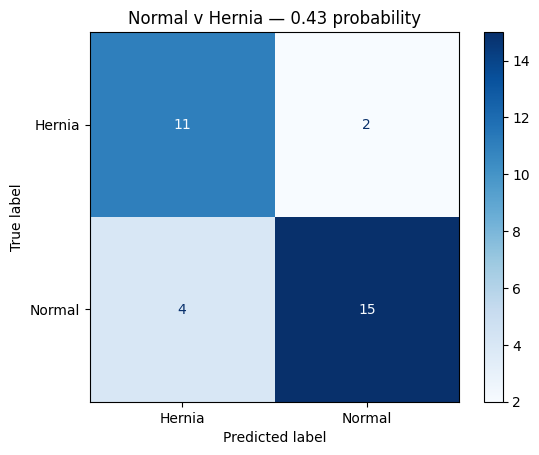

In [28]:
y_hernia_thresh_prob = classifier_tuned.predict_proba(X_hernia_rfe_test)[:, 0]
print(
    f'Accuracy: {accuracy_score(y_hernia_rfe_test, np.where(y_hernia_thresh_prob >= hernia_optimum_threshold, "Hernia", "Normal")):.4f}'
)
print(
    f'F1 Score: {f1_score(y_hernia_rfe_test, np.where(y_hernia_thresh_prob >= hernia_optimum_threshold, "Hernia", "Normal"), average="weighted"):.4f}'
)
print(
    f'False Negative Rate (FNR): {false_negative_rate(confusion_matrix(y_hernia_rfe_test, np.where(y_hernia_thresh_prob >= hernia_optimum_threshold, "Hernia", "Normal")))[0]:.4f}'
)

ConfusionMatrixDisplay(
    confusion_matrix=confusion_matrix(
        y_hernia_rfe_test,
        np.where(y_hernia_thresh_prob >= hernia_optimum_threshold, "Hernia", "Normal"),
    ),
    display_labels=lr_model_hernia_pipeline.classes_,
).plot(cmap=CMAP)

plt.title("Normal v Hernia — 0.43 probability")

## Spondy v Non-Spondy logistic regression model


Cross-validation results:
accuracy (train): 0.9744 ± 0.0020
accuracy (test): 0.9699 ± 0.0348
f1_weighted (train): 0.9743 ± 0.0020
f1_weighted (test): 0.9698 ± 0.0349
roc_auc (train): 0.9949 ± 0.0008
roc_auc (test): 0.9942 ± 0.0082

Final Model Performance on Test Data:
Accuracy: 0.9000
F1 Score: 0.9001
False Negative Rate (FNR): 0.0714
ROC AUC Score: 0.9732
                   precision    recall  f1-score   support

       Non-Spondy       0.87      0.93      0.90        28
Spondylolisthesis       0.93      0.88      0.90        32

         accuracy                           0.90        60
        macro avg       0.90      0.90      0.90        60
     weighted avg       0.90      0.90      0.90        60



Text(0.5, 1.0, 'Normal v Spondy — all features')

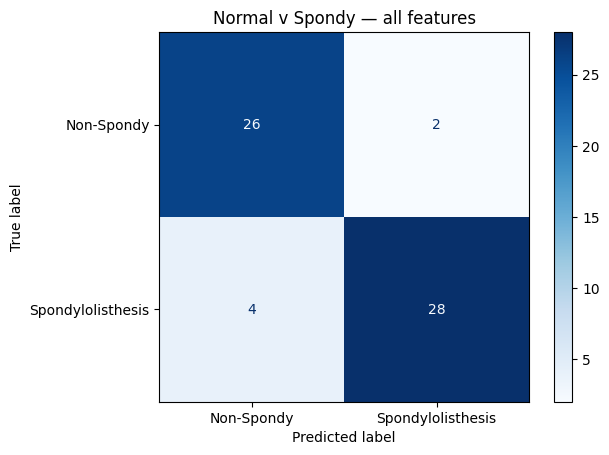

In [29]:
df_spondy = df.copy()
df_spondy.loc[df_spondy["class"].isin(["Normal", "Hernia"]), "class"] = "Non-Spondy"

X_spondy = df_spondy.drop(columns="class")
y_spondy = df_spondy["class"]

X_spondy_train: pd.DataFrame
X_spondy_test: pd.DataFrame
y_spondy_train: np.ndarray
y_spondy_test: np.ndarray
X_spondy_train, X_spondy_test, y_spondy_train, y_spondy_test = train_test_split(
    X_spondy, y_spondy.values.ravel(), test_size=TEST_SIZE, random_state=SEED
)

# Cross-validation scores
lr_spondy_cv_results: dict[str, np.ndarray] = cross_validate(
    lr_model_spondy_pipeline,
    X_spondy,
    y_spondy,
    cv=cv,
    scoring=BINARY_SCORING,
    return_train_score=True,
    n_jobs=-1,
)

# Results
print("Cross-validation results:")
for metric in BINARY_SCORING.keys():
    print(
        f"{metric} (train): {lr_spondy_cv_results[f'train_{metric}'].mean():.4f} ± {lr_spondy_cv_results[f'train_{metric}'].std():.4f}"
    )
    print(
        f"{metric} (test): {lr_spondy_cv_results[f'test_{metric}'].mean():.4f} ± {lr_spondy_cv_results[f'test_{metric}'].std():.4f}"
    )

# Final Model Training and Evaluation
lr_model_spondy_pipeline.fit(X_spondy_train, y_spondy_train)
y_spondy_pred = lr_model_spondy_pipeline.predict(X_spondy_test)
y_spondy_prob = lr_model_spondy_pipeline.predict_proba(X_spondy_test)[:, 1]

print("\nFinal Model Performance on Test Data:")
print(f"Accuracy: {accuracy_score(y_spondy_test, y_spondy_pred):.4f}")
print(f'F1 Score: {f1_score(y_spondy_test, y_spondy_pred, average="weighted"):.4f}')
print(f"False Negative Rate (FNR): {false_negative_rate(confusion_matrix(y_spondy_test, y_spondy_pred))[0]:.4f}")
print(f"ROC AUC Score: {roc_auc_score(y_spondy_test, y_spondy_prob):.4f}")
print(classification_report(y_spondy_test, y_spondy_pred))
ConfusionMatrixDisplay(
    confusion_matrix=confusion_matrix(y_spondy_test, y_spondy_pred),
    display_labels=lr_model_spondy_pipeline.classes_,
).plot(cmap=CMAP)
plt.title("Normal v Spondy — all features")

Optimal number of features: 1


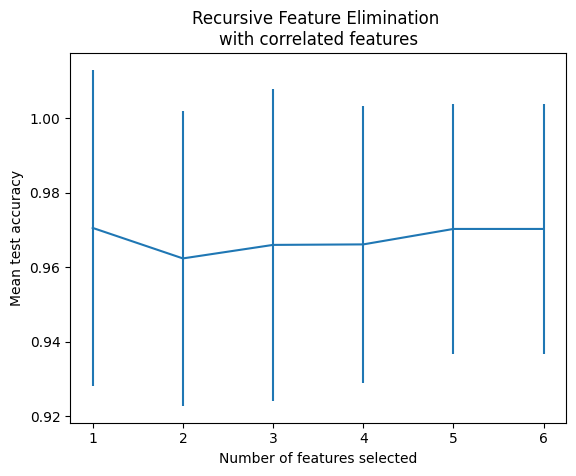

['degree_spondylolisthesis']

In [30]:
rfe_pipeline_with_rfecv(
    X_spondy_train, y_spondy_train, pipeline=lr_model_binary_pipeline
)

Cross-validation results:
accuracy (train): 0.9684 ± 0.0034
accuracy (test): 0.9666 ± 0.0258
f1_weighted (train): 0.9684 ± 0.0034
f1_weighted (test): 0.9665 ± 0.0259
roc_auc (train): 0.9912 ± 0.0017
roc_auc (test): 0.9902 ± 0.0161

Final Model Performance on Test Data:
Accuracy: 0.9500
F1 Score: 0.9500
False Negative Rate (FNR): 0.0357
ROC AUC Score: 0.9933
                   precision    recall  f1-score   support

       Non-Spondy       0.93      0.96      0.95        28
Spondylolisthesis       0.97      0.94      0.95        32

         accuracy                           0.95        60
        macro avg       0.95      0.95      0.95        60
     weighted avg       0.95      0.95      0.95        60



Text(0.5, 1.0, 'Spondy v Non-Spondy — one feature')

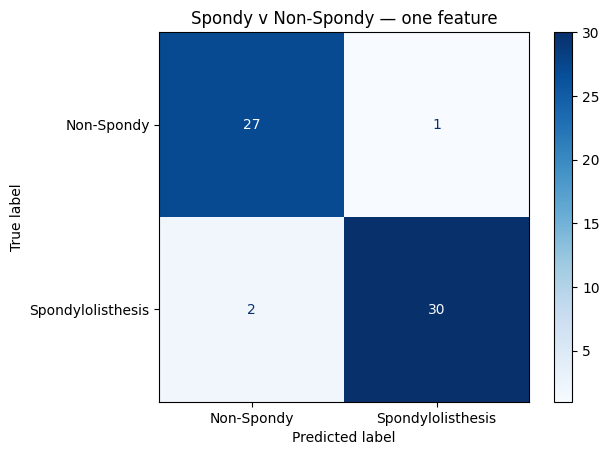

In [31]:
X_spondy_rfe = X_spondy[["degree_spondylolisthesis"]]

X_spondy_rfe_train: pd.DataFrame
X_spondy_rfe_test: pd.DataFrame
y_spondy_rfe_train: np.ndarray
y_spondy_rfe_test: np.ndarray
X_spondy_rfe_train, X_spondy_rfe_test, y_spondy_rfe_train, y_spondy_rfe_test = (
    train_test_split(
        X_spondy_rfe, y_spondy.values.ravel(), test_size=TEST_SIZE, random_state=SEED
    )
)

# Cross-validation scores
lr_spondy_feature_selection_cv_results = cross_validate(
    lr_model_spondy_pipeline,
    X_spondy_rfe,
    y_spondy,
    cv=cv,
    scoring=BINARY_SCORING,
    return_train_score=True,
    n_jobs=-1,
)

# Results
print("Cross-validation results:")
for metric in BINARY_SCORING.keys():
    print(
        f"{metric} (train): {lr_spondy_feature_selection_cv_results[f'train_{metric}'].mean():.4f} ± {lr_spondy_feature_selection_cv_results[f'train_{metric}'].std():.4f}"
    )
    print(
        f"{metric} (test): {lr_spondy_feature_selection_cv_results[f'test_{metric}'].mean():.4f} ± {lr_spondy_feature_selection_cv_results[f'test_{metric}'].std():.4f}"
    )

# Final Model Training and Evaluation
lr_model_spondy_pipeline.fit(X_spondy_rfe_train, y_spondy_rfe_train)
y_spondy_rfe_pred = lr_model_spondy_pipeline.predict(X_spondy_rfe_test)
y_spondy_rfe_prob = lr_model_spondy_pipeline.predict_proba(X_spondy_rfe_test)[:, 1]

print("\nFinal Model Performance on Test Data:")
print(f"Accuracy: {accuracy_score(y_spondy_rfe_test, y_spondy_rfe_pred):.4f}")
print(
    f'F1 Score: {f1_score(y_spondy_rfe_test, y_spondy_rfe_pred, average="weighted"):.4f}'
)
print(f"False Negative Rate (FNR): {false_negative_rate(confusion_matrix(y_spondy_rfe_test, y_spondy_rfe_pred))[0]:.4f}")
print(f"ROC AUC Score: {roc_auc_score(y_spondy_rfe_test, y_spondy_rfe_prob):.4f}")
print(classification_report(y_spondy_rfe_test, y_spondy_rfe_pred))
ConfusionMatrixDisplay(
    confusion_matrix=confusion_matrix(y_spondy_rfe_test, y_spondy_rfe_pred),
    display_labels=lr_model_spondy_pipeline.classes_,
).plot(cmap=CMAP)
plt.title("Spondy v Non-Spondy — one feature")

## Hierarchical classification


In [32]:
# Spondy v Non-Spondy classification
df_spondy_predicted = X_multi_class_test.reset_index(drop=True).copy()
df_spondy_predicted["class"] = pd.DataFrame(
    lr_model_spondy_pipeline.predict(X_multi_class_test[["degree_spondylolisthesis"]]),
    columns=["class"],
)
df_spondy_predicted["spondy_proba"] = pd.DataFrame(
    lr_model_spondy_pipeline.predict_proba(
        X_multi_class_test[["degree_spondylolisthesis"]]
    )[:, 1],
    columns=["spondy_proba"],
)
df_spondy_predicted["hernia_proba"] = 0.0
df_spondy_predicted["normal_proba"] = 0.0

In [33]:
# Non-Spondy bifurcation
non_spondy_df = df_spondy_predicted[df_spondy_predicted["class"] == "Non-Spondy"].copy()

feature_columns = [
    "pelvic_tilt",
    "lumbar_lordosis_angle",
    "sacral_slope",
    "pelvic_radius",
]
features = non_spondy_df[feature_columns]

non_spondy_df["prediction"] = lr_model_hernia_pipeline.predict(features)
df_spondy_predicted.loc[df_spondy_predicted["class"] == "Non-Spondy", "prediction"] = (
    non_spondy_df["prediction"]
)

In [34]:
y_hierarchical_pred = np.where(
    df_spondy_predicted["prediction"].notna(),
    df_spondy_predicted["prediction"],
    df_spondy_predicted["class"],
)


Final Model Performance on Test Data:
Accuracy: 0.8167
F1 Score: 0.8153
Hernia False Negative Rate (FNR): 0.5000
Normal False Negative Rate (FNR): 0.1875
Spondy False Negative Rate (FNR): 0.0625
                   precision    recall  f1-score   support

           Hernia       0.75      0.50      0.60        12
           Normal       0.62      0.81      0.70        16
Spondylolisthesis       0.97      0.94      0.95        32

         accuracy                           0.82        60
        macro avg       0.78      0.75      0.75        60
     weighted avg       0.83      0.82      0.82        60



Text(0.5, 1.0, 'Hierarchical model')

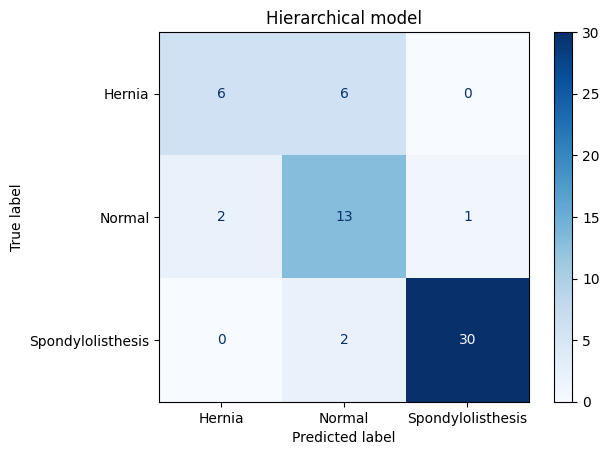

In [35]:
print("\nFinal Model Performance on Test Data:")
print(f"Accuracy: {accuracy_score(y_multi_class_test, y_hierarchical_pred):.4f}")
print(
    f'F1 Score: {f1_score(y_multi_class_test, y_hierarchical_pred, average="weighted"):.4f}'
)
print(f"Hernia False Negative Rate (FNR): {false_negative_rate(confusion_matrix(y_multi_class_test, y_hierarchical_pred))[0]:.4f}")
print(f"Normal False Negative Rate (FNR): {false_negative_rate(confusion_matrix(y_multi_class_test, y_hierarchical_pred))[1]:.4f}")
print(f"Spondy False Negative Rate (FNR): {false_negative_rate(confusion_matrix(y_multi_class_test, y_hierarchical_pred))[2]:.4f}")
print(classification_report(y_multi_class_test, y_hierarchical_pred))
ConfusionMatrixDisplay(
    confusion_matrix=confusion_matrix(y_multi_class_test, y_hierarchical_pred),
    display_labels=lr_model_multi_class_pipeline.classes_,
).plot(cmap=CMAP)
plt.title("Hierarchical model")

In [36]:
from hierarchical_model import HierarchicalModel

# The HierarchicalModel is similar to the above code, the modularity helps us reload that in the front-end
hierarchical_model = HierarchicalModel(
    spondy_pipeline=lr_model_spondy_pipeline,
    hernia_pipeline=lr_model_hernia_pipeline,
    hernia_threshold=hernia_optimum_threshold,
)


Final Model Performance on Test Data:
Accuracy: 0.8500
F1 Score: 0.8519
Hernia False Negative Rate (FNR): 0.2500
Normal False Negative Rate (FNR): 0.2500
Spondy False Negative Rate (FNR): 0.0625
                   precision    recall  f1-score   support

           Hernia       0.75      0.75      0.75        12
           Normal       0.71      0.75      0.73        16
Spondylolisthesis       0.97      0.94      0.95        32

         accuracy                           0.85        60
        macro avg       0.81      0.81      0.81        60
     weighted avg       0.85      0.85      0.85        60



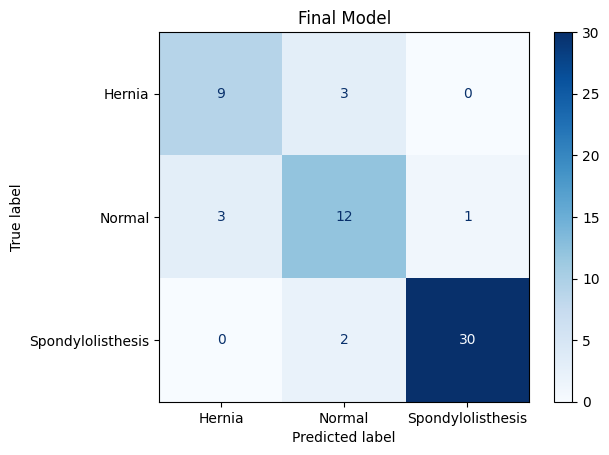

In [37]:
# Evaluate model performance
from sklearn.metrics import (
    f1_score,
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
)
import matplotlib.pyplot as plt

predictions = hierarchical_model.predict(X_multi_class_test)

y_hierarchical_pred = predictions["final_prediction"]
print("\nFinal Model Performance on Test Data:")
print(f"Accuracy: {accuracy_score(y_multi_class_test, y_hierarchical_pred):.4f}")
print(
    f'F1 Score: {f1_score(y_multi_class_test, y_hierarchical_pred, average="weighted"):.4f}'
)
print(
    f"Hernia False Negative Rate (FNR): {false_negative_rate(confusion_matrix(y_multi_class_test, y_hierarchical_pred))[0]:.4f}"
)
print(
    f"Normal False Negative Rate (FNR): {false_negative_rate(confusion_matrix(y_multi_class_test, y_hierarchical_pred))[1]:.4f}"
)
print(
    f"Spondy False Negative Rate (FNR): {false_negative_rate(confusion_matrix(y_multi_class_test, y_hierarchical_pred))[2]:.4f}"
)
print(classification_report(y_multi_class_test, y_hierarchical_pred))
ConfusionMatrixDisplay(
    confusion_matrix=confusion_matrix(y_multi_class_test, y_hierarchical_pred),
    display_labels=["Hernia", "Normal", "Spondylolisthesis"],
).plot(cmap="Blues")
plt.title("Final Model")
plt.show()

## Export models/data

In [38]:
import joblib
import os

os.makedirs("models", exist_ok=True)
os.makedirs("parquets", exist_ok=True)
joblib.dump(lr_model_binary_pipeline, "models/normal_v_abnormal.pkl")
joblib.dump(lr_model_hernia_pipeline, "models/hernia.pkl")
joblib.dump(lr_model_spondy_pipeline, "models/spondy.pkl")
hierarchical_model.save("models/hierarchical.pkl")

X_binary_rfe_train.to_parquet("parquets/X_binary_rfe_train.parquet")
X_multi_class_train.to_parquet("parquets/X_multi_class_train.parquet")

## NN model - Binary


In [39]:
import keras_tuner as kt
import keras
import tensorflow as tf
from typing import Any

keras.utils.set_random_seed(SEED)

X_binary_train, X_binary_test, y_binary_train, y_binary_test = train_test_split(
    X_binary, y_binary.values.ravel(), test_size=TEST_SIZE, random_state=SEED
)
scaler = StandardScaler()
X_binary_train_scaled = scaler.fit_transform(X_binary_train)
X_binary_test_scaled = scaler.transform(X_binary_test)

y_binary_train_onehot = np.expand_dims(
    np.where(y_binary_train == "Normal", 0, 1), axis=-1
)
y_binary_test_onehot = np.expand_dims(
    np.where(y_binary_test == "Normal", 0, 1), axis=-1
)

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss", patience=20, restore_best_weights=True
)

lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(
    monitor="val_loss", factor=0.5, patience=5, min_lr=1e-6
)


class BinaryNNModel(kt.HyperModel):
    def __init__(self, input_shape):
        self.input_shape = input_shape

    def build(self, hp):
        model = tf.keras.Sequential()
        # Input Layer
        model.add(tf.keras.layers.Input(shape=(self.input_shape,)))
        model.add(
            tf.keras.layers.Dense(
                hp.Int("units_input", min_value=8, max_value=256, step=8),
                activation=hp.Choice("activation_input", ["relu", "leaky_relu"]),
                kernel_regularizer=tf.keras.regularizers.l2(
                    hp.Float("l2_input", min_value=1e-5, max_value=1e-2, sampling="log")
                ),
            )
        )
        model.add(
            tf.keras.layers.Dropout(
                hp.Float("dropout_1", min_value=0.1, max_value=0.6, step=0.1)
            )
        )
        # Hidden Layers
        for i in range(hp.Int("num_hidden_layers", 0, 25)):
            model.add(
                tf.keras.layers.Dense(
                    hp.Int(f"units_hidden_{i}", min_value=8, max_value=128, step=8),
                    activation=hp.Choice("activation_hidden", ["relu", "elu"]),
                    kernel_regularizer=tf.keras.regularizers.l2(
                        hp.Float(
                            f"l2_hidden_{i}",
                            min_value=1e-20,
                            max_value=1e-3,
                            sampling="log",
                        )
                    ),
                )
            )
            model.add(
                tf.keras.layers.Dropout(
                    hp.Float(f"dropout_{i+2}", min_value=0.1, max_value=0.6, step=0.1)
                )
            )
        # Output Layer
        model.add(tf.keras.layers.Dense(1, activation="sigmoid"))
        # Compile Model
        model.compile(
            optimizer=tf.keras.optimizers.Adam(
                hp.Float("learning_rate", 1e-6, 1e-2, sampling="log")
            ),
            loss="binary_crossentropy",
            metrics=[keras.metrics.F1Score(average="weighted", threshold=0.5)],
        )
        return model

    def fit(self, hp, model, *args, **kwargs):
        return model.fit(
            *args,
            batch_size=hp.Choice("batch_size", [8, 16, 32, 64, 128]),
            **kwargs,
        )


binary_tuner = kt.BayesianOptimization(
    BinaryNNModel(input_shape=X_binary_train_scaled.shape[1]),
    objective=kt.Objective("val_f1_score", direction="max"),
    max_trials=MAX_TRIALS,
    seed=SEED,
    overwrite=False,  # set to True if you want to retrain, i.e. ignore the checkpoints
    directory="tuning_dir",
    project_name="binary_classification"
)

binary_tuner.search(
    X_binary_train_scaled,
    y_binary_train_onehot,
    epochs=100,
    validation_split=TEST_SIZE,
    callbacks=[early_stopping, lr_scheduler],
)

# Retrieve the best hyperparameters
best_binary_hyperparameters = binary_tuner.get_best_hyperparameters()[0]
best_binary_hyperparameters = binary_tuner.oracle.get_best_trials(num_trials=1)[
    0
].hyperparameters
best_binary_model = binary_tuner.hypermodel.build(best_binary_hyperparameters)

# Train the best model
binary_model_history = best_binary_model.fit(
    X_binary_train_scaled,
    y_binary_train_onehot,
    epochs=100,
    validation_split=TEST_SIZE,
    batch_size=best_binary_hyperparameters.get("batch_size"),
    callbacks=[early_stopping],
)


def kt_find_best_epoch(model_history: Any, metric: str = "val_f1_score") -> int:
    "Find best epoch from the keras model tuned with keras-tuner"
    return model_history.history[metric].index(max(model_history.history[metric])) + 1


# Find best epoch
best_binary_epoch = kt_find_best_epoch(binary_model_history)
best_binary_epoch

Trial 30 Complete [00h 00m 06s]
val_f1_score: 0.8799999356269836

Best val_f1_score So Far: 0.9333332777023315
Total elapsed time: 00h 05m 20s
Epoch 1/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - f1_score: 0.6230 - loss: 0.7160 - val_f1_score: 0.3529 - val_loss: 0.7295
Epoch 2/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - f1_score: 0.6064 - loss: 0.7874 - val_f1_score: 0.6769 - val_loss: 0.7187
Epoch 3/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - f1_score: 0.5812 - loss: 0.7616 - val_f1_score: 0.7324 - val_loss: 0.7086
Epoch 4/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - f1_score: 0.5623 - loss: 0.7842 - val_f1_score: 0.7671 - val_loss: 0.6984
Epoch 5/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - f1_score: 0.6127 - loss: 0.7857 - val_f1_score: 0.7632 - val_loss: 0.6907
Epoch 6/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - f1_score: 0.4894 - loss: 0.7981 - val_f1_score: 0.7632 - val_loss: 0.6832
Epoch 7/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - f1_score: 0.6261 - loss: 0.7628 - val_f1_

67

In [40]:
best_binary_model = binary_tuner.hypermodel.build(best_binary_hyperparameters)

# Retrain the model with best hyperparameters and epoch
best_binary_model.fit(
    X_binary_train_scaled,
    y_binary_train_onehot,
    epochs=best_binary_epoch,
    validation_split=TEST_SIZE,
    batch_size=best_binary_hyperparameters.get("batch_size"),
)

Epoch 1/67
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - f1_score: 0.5945 - loss: 0.7323 - val_f1_score: 0.6296 - val_loss: 0.7152
Epoch 2/67
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - f1_score: 0.4930 - loss: 0.7851 - val_f1_score: 0.6296 - val_loss: 0.7076
Epoch 3/67
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - f1_score: 0.5811 - loss: 0.7610 - val_f1_score: 0.6429 - val_loss: 0.7010
Epoch 4/67
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - f1_score: 0.5153 - loss: 0.8137 - val_f1_score: 0.7333 - val_loss: 0.6933
Epoch 5/67
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - f1_score: 0.6159 - loss: 0.7577 - val_f1_score: 0.7541 - val_loss: 0.6854
Epoch 6/67
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - f1_score: 0.6291 - loss: 0.7154 - val_f1_score: 0.7742 - val_loss: 0.6773
Epoch 7/67
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - f1_score: 0.6740 - loss: 0.6674 - val_f1_score: 0.7619 - val_loss: 0.6701
Epoch 8/67
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - f1_score: 0.6184 - loss: 0.7218 - val_f1_score: 0.7812 - val_loss

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
Accuracy: 0.6833
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
F1 Score: 0.7000514562107647
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
False Negative Rate (FNR): 0.3182
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


Text(0.5, 1.0, 'NN Normal v Abnormal')

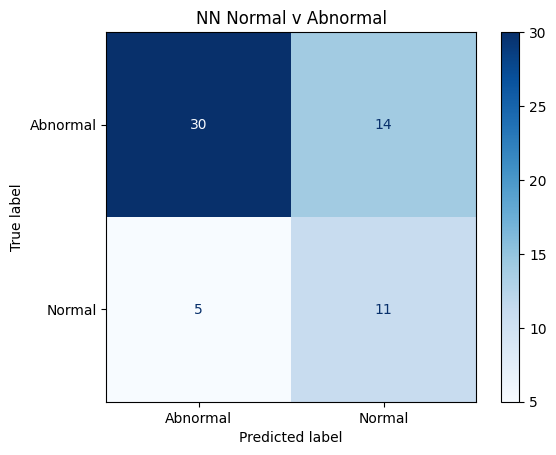

In [41]:
print(
    f"Accuracy: {accuracy_score(y_binary_test_onehot, (best_binary_model.predict(X_binary_test_scaled) > 0.5).astype(int)):.4f}"
)
print(
    f'F1 Score: {f1_score(y_binary_test_onehot, (best_binary_model.predict(X_binary_test_scaled) > 0.5).astype(int), average="weighted")}'
)
print(
    f"False Negative Rate (FNR): {false_negative_rate(confusion_matrix(y_binary_test_onehot, (best_binary_model.predict(X_binary_test_scaled) > 0.5).astype(int))[::-1, ::-1])[0]:.4f}"
)

ConfusionMatrixDisplay(
    confusion_matrix=confusion_matrix(
        y_binary_test_onehot,
        (best_binary_model.predict(X_binary_test_scaled) > 0.5).astype(int),
    )[::-1, ::-1],
    display_labels=["Abnormal", "Normal"],
).plot(cmap=CMAP)
plt.title("NN Normal v Abnormal")

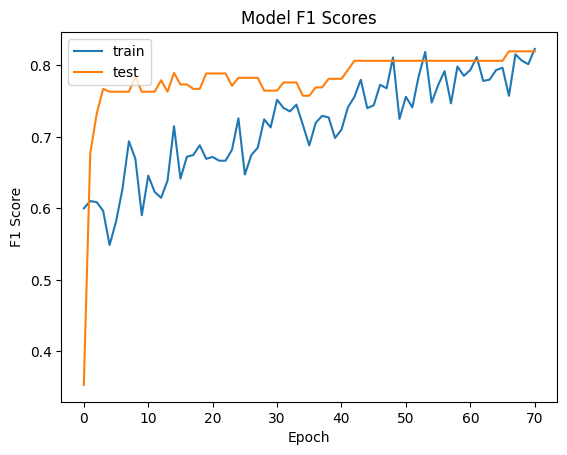

In [42]:
# Plot training vs. validation metrics
plt.plot(binary_model_history.history["f1_score"])
plt.plot(binary_model_history.history["val_f1_score"])
plt.title("Model F1 Scores")
plt.ylabel("F1 Score")
plt.xlabel("Epoch")
plt.legend(["train", "test"], loc="upper left")
plt.show()

## NN model - Multiclass


In [43]:
from sklearn.preprocessing import OneHotEncoder


X_multi_class = df.drop(columns="class")
y_multi_class = df["class"]
X_multi_class_train, X_multi_class_test, y_multi_class_train, y_multi_class_test = (
    train_test_split(
        X_multi_class,
        y_multi_class.values.ravel(),
        test_size=TEST_SIZE,
        random_state=SEED,
    )
)

scaler = StandardScaler()
X_multi_class_train_scaled = scaler.fit_transform(X_multi_class_train)
X_multi_class_test_scaled = scaler.transform(X_multi_class_test)

encoder = OneHotEncoder(sparse_output=False)
y_multi_class_train_onehot = encoder.fit_transform(y_multi_class_train.reshape(-1, 1))
y_multi_class_test_onehot = encoder.transform(y_multi_class_test.reshape(-1, 1))


class MultiClassNNModel(kt.HyperModel):
    def __init__(self, input_shape):
        self.input_shape = input_shape
    def build(self, hp):
        model = tf.keras.Sequential()
        # Input Layer
        model.add(
            tf.keras.layers.Input(
                shape=(self.input_shape,)
            )
        )
        model.add(
            tf.keras.layers.Dense(
                hp.Int("units_input", min_value=8, max_value=256, step=8),
                activation=hp.Choice("activation_input", ["relu", "leaky_relu"]),
                kernel_regularizer=tf.keras.regularizers.l2(
                    hp.Float("l2_input", min_value=1e-5, max_value=1e-2, sampling="log")
                ),
            )
        )
        model.add(
            tf.keras.layers.Dropout(
                hp.Float("dropout_1", min_value=0.1, max_value=0.6, step=0.1)
            )
        )
        # Hidden Layers
        for i in range(hp.Int("num_hidden_layers", 0, 25)):
            model.add(
                tf.keras.layers.Dense(
                    hp.Int(f"units_hidden_{i}", min_value=8, max_value=128, step=8),
                    activation=hp.Choice("activation_hidden", ["relu", "elu"]),
                    kernel_regularizer=tf.keras.regularizers.l2(
                        hp.Float(
                            f"l2_hidden_{i}",
                            min_value=1e-20,
                            max_value=1e-3,
                            sampling="log",
                        )
                    ),
                )
            )
            model.add(
                tf.keras.layers.Dropout(
                    hp.Float(f"dropout_{i+2}", min_value=0.1, max_value=0.6, step=0.1)
                )
            )
        # Output Layer
        model.add(tf.keras.layers.Dense(3, activation="softmax"))
        # Compile Model
        model.compile(
            optimizer=tf.keras.optimizers.Adam(
                hp.Float("learning_rate", 1e-6, 1e-2, sampling="log")
            ),
            loss="categorical_crossentropy",
            metrics=[keras.metrics.F1Score(average="weighted", threshold=0.5)],
        )
        return model

    def fit(self, hp, model, *args, **kwargs):
        return model.fit(
            *args,
            batch_size=hp.Choice("batch_size", [8, 16, 32, 64, 128]),
            **kwargs,
        )


multi_class_tuner = kt.BayesianOptimization(
    MultiClassNNModel(input_shape=X_multi_class_train_scaled.shape[1]),
    objective=kt.Objective("val_f1_score", direction="max"),
    max_trials=MAX_TRIALS,
    seed=SEED,
    overwrite=False,  # set to True if you want to retrain, i.e. ignore the checkpoints
    directory="tuning_dir",
    project_name="multi_class"
)

multi_class_tuner.search(
    X_multi_class_train_scaled,
    y_multi_class_train_onehot,
    epochs=100,
    validation_split=TEST_SIZE,
    callbacks=[early_stopping, lr_scheduler],
)

# Retrieve the best hyperparameters
best_multi_class_hyperparameters = multi_class_tuner.get_best_hyperparameters()[0]
best_multi_class_model = multi_class_tuner.hypermodel.build(
    best_multi_class_hyperparameters
)

# Train the best model
multi_class_model_history = best_multi_class_model.fit(
    X_multi_class_train_scaled,
    y_multi_class_train_onehot,
    epochs=100,
    validation_split=TEST_SIZE,
    batch_size=best_multi_class_hyperparameters.get("batch_size"),
    callbacks=[early_stopping],
)

best_multi_class_epoch = kt_find_best_epoch(multi_class_model_history)
best_multi_class_epoch

Trial 30 Complete [00h 00m 11s]
val_f1_score: 0.6796770095825195

Best val_f1_score So Far: 0.925595223903656
Total elapsed time: 00h 06m 31s
Epoch 1/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 154ms/step - f1_score: 0.1971 - loss: 1.0273 - val_f1_score: 0.2096 - val_loss: 0.9535
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - f1_score: 0.3093 - loss: 0.9586 - val_f1_score: 0.3856 - val_loss: 0.8587
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - f1_score: 0.4172 - loss: 0.8682 - val_f1_score: 0.5128 - val_loss: 0.7787
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - f1_score: 0.5285 - loss: 0.8071 - val_f1_score: 0.5891 - val_loss: 0.7120
Epoch 5/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - f1_score: 0.5941 - loss: 0.7401 - val_f1_score: 0.6287 - val_loss: 0.6567
Epoch 6/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - f1_score: 0.5760 - loss: 0.7191 - val_f1_score: 0.6422 - val_loss: 0.6110
Epoch 7/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - f1_score: 0.6192 - loss: 0.6808 - val_f1_score: 0

47

In [44]:
best_multi_class_model = multi_class_tuner.hypermodel.build(
    best_multi_class_hyperparameters
)

# Retrain the model with best hyperparameters and epoch
best_multi_class_model.fit(
    X_multi_class_train_scaled,
    y_multi_class_train_onehot,
    epochs=best_multi_class_epoch,
    validation_split=TEST_SIZE,
    batch_size=best_multi_class_hyperparameters.get("batch_size"),
)

Epoch 1/47
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 147ms/step - f1_score: 0.1345 - loss: 1.0440 - val_f1_score: 0.3328 - val_loss: 0.8864
Epoch 2/47
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - f1_score: 0.3171 - loss: 0.9570 - val_f1_score: 0.4959 - val_loss: 0.7938
Epoch 3/47
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - f1_score: 0.3673 - loss: 0.8812 - val_f1_score: 0.5711 - val_loss: 0.7165
Epoch 4/47
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - f1_score: 0.4817 - loss: 0.7842 - val_f1_score: 0.6292 - val_loss: 0.6525
Epoch 5/47
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - f1_score: 0.5545 - loss: 0.7427 - val_f1_score: 0.6390 - val_loss: 0.6000
Epoch 6/47
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - f1_score: 0.5898 - loss: 0.7042 - val_f1_score: 0.6667 - val_loss: 0.5570
Epoch 7/47
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - f1_score: 0.6324 - loss: 0.6646 - val_f1_score: 0.6667 - val_loss: 0.5207
Epoch 8/47
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - f1_score: 0.6738 - loss: 0.6310 - val_f1_score: 0.6778 - val_loss: 0.4907

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Accuracy: 0.7667
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
F1 Score: 0.767047047047047
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Hernia False Negative Rate (FNR): 0.5000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Normal False Negative Rate (FNR): 0.2500
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Spondy False Negative Rate (FNR): 0.1250
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


Text(0.5, 1.0, 'NN Multiclass')

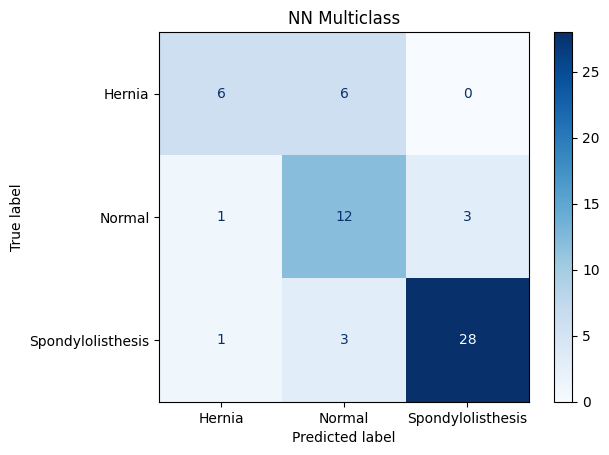

In [45]:
print(
    f"Accuracy: {accuracy_score(np.argmax(y_multi_class_test_onehot, axis=1), (np.argmax(best_multi_class_model.predict(X_multi_class_test_scaled), axis=1))):.4f}"
)
print(
    f'F1 Score: {f1_score(np.argmax(y_multi_class_test_onehot, axis=1), np.argmax(best_multi_class_model.predict(X_multi_class_test_scaled), axis=1), average="weighted")}'
)
print(
    f"Hernia False Negative Rate (FNR): {false_negative_rate(confusion_matrix(np.argmax(y_multi_class_test_onehot, axis=1),np.argmax(best_multi_class_model.predict(X_multi_class_test_scaled), axis=1)))[0]:.4f}"
)
print(
    f"Normal False Negative Rate (FNR): {false_negative_rate(confusion_matrix(np.argmax(y_multi_class_test_onehot, axis=1),np.argmax(best_multi_class_model.predict(X_multi_class_test_scaled), axis=1)))[1]:.4f}"
)
print(
    f"Spondy False Negative Rate (FNR): {false_negative_rate(confusion_matrix(np.argmax(y_multi_class_test_onehot, axis=1), np.argmax(best_multi_class_model.predict(X_multi_class_test_scaled), axis=1)))[2]:.4f}"
)
ConfusionMatrixDisplay(
    confusion_matrix=confusion_matrix(
        np.argmax(y_multi_class_test_onehot, axis=1),
        np.argmax(
            best_multi_class_model.predict(X_multi_class_test_scaled), axis=1
        ),
    ),
    display_labels=["Hernia", "Normal", "Spondylolisthesis"],
).plot(cmap=CMAP)
plt.title("NN Multiclass")

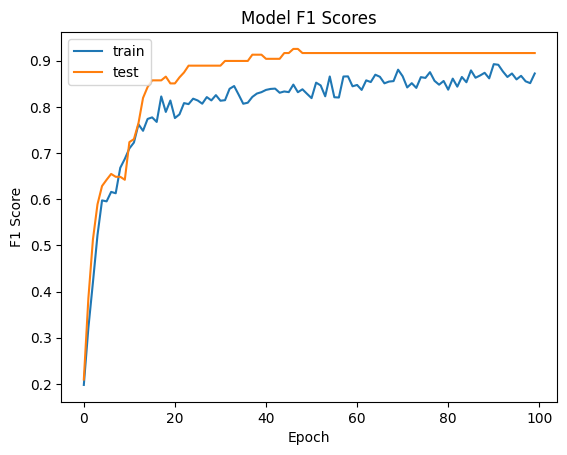

In [46]:
# Plot training vs. validation metrics
plt.plot(multi_class_model_history.history["f1_score"])
plt.plot(multi_class_model_history.history["val_f1_score"])
plt.title("Model F1 Scores")
plt.ylabel("F1 Score")
plt.xlabel("Epoch")
plt.legend(["train", "test"], loc="upper left")
plt.show()

## NN model - Normal v Hernia


In [47]:
X_hernia_train, X_hernia_test, y_hernia_train, y_hernia_test = train_test_split(
    X_hernia, y_hernia.values.ravel(), test_size=TEST_SIZE, random_state=SEED
)
scaler = StandardScaler()
X_hernia_train_scaled = scaler.fit_transform(X_hernia_train)
X_hernia_test_scaled = scaler.transform(X_hernia_test)

y_hernia_train_onehot = np.expand_dims(
    np.where(y_hernia_train == "Normal", 0, 1), axis=-1
)
y_hernia_test_onehot = np.expand_dims(
    np.where(y_hernia_test == "Normal", 0, 1), axis=-1
)

hernia_tuner = kt.BayesianOptimization(
    BinaryNNModel(input_shape=X_hernia_train_scaled.shape[1]),
    objective=kt.Objective("val_f1_score", direction="max"),
    max_trials=MAX_TRIALS,
    seed=SEED,
    overwrite=False,  # set to True if you want to retrain, i.e. ignore the checkpoints
    directory="tuning_dir",
    project_name="hernia_classification",
)

hernia_tuner.search(
    X_hernia_train_scaled,
    y_hernia_train_onehot,
    epochs=100,
    validation_split=TEST_SIZE,
    callbacks=[early_stopping, lr_scheduler],
)

# Retrieve the best hyperparameters
best_hernia_hyperparameters = hernia_tuner.get_best_hyperparameters()[0]
best_hernia_model = hernia_tuner.hypermodel.build(best_hernia_hyperparameters)

# Train the best model
hernia_model_history = best_hernia_model.fit(
    X_hernia_train_scaled,
    y_hernia_train_onehot,
    epochs=100,
    validation_split=TEST_SIZE,
    batch_size=best_hernia_hyperparameters.get("batch_size"),
    callbacks=[early_stopping]
)

# Find best epoch
best_hernia_epoch = kt_find_best_epoch(hernia_model_history)
best_hernia_epoch

Trial 30 Complete [00h 00m 09s]
val_f1_score: 0.8181817531585693

Best val_f1_score So Far: 0.8421052098274231
Total elapsed time: 00h 07m 00s
Epoch 1/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - f1_score: 0.3869 - loss: 0.7340 - val_f1_score: 0.5000 - val_loss: 0.5462
Epoch 2/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - f1_score: 0.5400 - loss: 0.6609 - val_f1_score: 0.8421 - val_loss: 0.3931
Epoch 3/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - f1_score: 0.7590 - loss: 0.6786 - val_f1_score: 0.8421 - val_loss: 0.3790
Epoch 4/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - f1_score: 0.6474 - loss: 0.5846 - val_f1_score: 0.7500 - val_loss: 0.4321
Epoch 5/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - f1_score: 0.5845 - loss: 0.5840 - val_f1_score: 0.7778 - val_loss: 0.3893
Epoch 6/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - f1_score: 0.6701 - loss: 0.5050 - val_f1_score: 0.8421 - val_loss: 0.3632
Epoch 7/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - f1_score: 0.7787 - loss: 0.4790 - val_f1_score: 0

19

In [48]:
best_hernia_model = hernia_tuner.hypermodel.build(best_hernia_hyperparameters)

# Retrain the model with best hyperparameters and epoch
best_hernia_model.fit(
    X_hernia_train_scaled,
    y_hernia_train_onehot,
    epochs=best_hernia_epoch,
    validation_split=TEST_SIZE,
    batch_size=best_hernia_hyperparameters.get("batch_size"),
)

Epoch 1/19
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - f1_score: 0.5038 - loss: 0.6896 - val_f1_score: 0.7059 - val_loss: 0.4776
Epoch 2/19
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - f1_score: 0.6638 - loss: 0.6494 - val_f1_score: 0.7368 - val_loss: 0.4584
Epoch 3/19
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - f1_score: 0.7525 - loss: 0.4646 - val_f1_score: 0.7778 - val_loss: 0.4510
Epoch 4/19
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - f1_score: 0.6683 - loss: 0.5866 - val_f1_score: 0.7059 - val_loss: 0.4577
Epoch 5/19
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - f1_score: 0.6041 - loss: 0.6579 - val_f1_score: 0.7368 - val_loss: 0.4265
Epoch 6/19
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - f1_score: 0.8051 - loss: 0.5158 - val_f1_score: 0.7368 - val_loss: 0.4256
Epoch 7/19
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - f1_score: 0.7599 - loss: 0.4866 - val_f1_score: 0.7778 - val_loss: 0.4477
Epoch 8/19
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - f1_score: 0.6648 - loss: 0.5247 - val_f1_score: 0.7778 - val_loss: 0.4450


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
Accuracy: 0.8125
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
F1 Score: 0.8139705882352941
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
False Negative Rate (FNR): 0.0769
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Text(0.5, 1.0, 'NN Normal v Hernia')

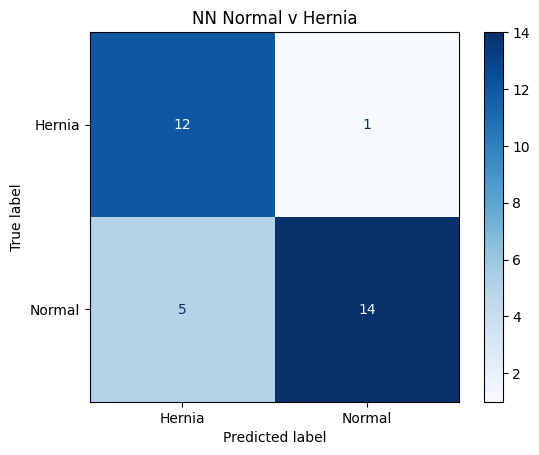

In [49]:
print(
    f"Accuracy: {accuracy_score(y_hernia_test_onehot, (best_hernia_model.predict(X_hernia_test_scaled) > 0.5).astype(int)):.4f}"
)
print(
    f'F1 Score: {f1_score(y_hernia_test_onehot, (best_hernia_model.predict(X_hernia_test_scaled) > 0.5).astype(int), average="weighted")}'
)
print(
    f"False Negative Rate (FNR): {false_negative_rate(confusion_matrix(y_hernia_test_onehot,(best_hernia_model.predict(X_hernia_test_scaled) > 0.5).astype(int),)[::-1, ::-1])[0]:.4f}"
)
ConfusionMatrixDisplay(
    confusion_matrix=confusion_matrix(
        y_hernia_test_onehot,
        (best_hernia_model.predict(X_hernia_test_scaled) > 0.5).astype(int),
    )[::-1, ::-1],
    display_labels=["Hernia", "Normal"],
).plot(cmap=CMAP)
plt.title("NN Normal v Hernia")

## NN model - Spondy v Non-Spondy


In [50]:
X_spondy_train, X_spondy_test, y_spondy_train, y_spondy_test = train_test_split(
    X_spondy, y_spondy.values.ravel(), test_size=TEST_SIZE, random_state=SEED
)
scaler = StandardScaler()
X_spondy_train_scaled = scaler.fit_transform(X_spondy_train)
X_spondy_test_scaled = scaler.transform(X_spondy_test)

y_spondy_train_onehot = np.expand_dims(
    np.where(y_spondy_train == "Non-Spondy", 0, 1), axis=-1
)
y_spondy_test_onehot = np.expand_dims(
    np.where(y_spondy_test == "Non-Spondy", 0, 1), axis=-1
)

spondy_tuner = kt.BayesianOptimization(
    BinaryNNModel(input_shape=X_spondy_train_scaled.shape[1]),
    objective=kt.Objective("val_f1_score", direction="max"),
    max_trials=MAX_TRIALS,
    seed=SEED,
    overwrite=False,  # set to True if you want to retrain, i.e. ignore the checkpoints
    directory="tuning_dir",
    project_name="spondy_classification",
)

spondy_tuner.search(
    X_spondy_train_scaled,
    y_spondy_train_onehot,
    epochs=100,
    validation_split=TEST_SIZE,
    callbacks=[early_stopping, lr_scheduler]
)

# Retrieve the best hyperparameters
best_spondy_hyperparameters = spondy_tuner.get_best_hyperparameters()[0]
best_spondy_model = spondy_tuner.hypermodel.build(best_spondy_hyperparameters)

# Train the best model
spondy_model_history = best_spondy_model.fit(
    X_spondy_train_scaled,
    y_spondy_train_onehot,
    epochs=100,
    validation_split=TEST_SIZE,
    batch_size=best_spondy_hyperparameters.get("batch_size"),
    callbacks=[early_stopping],
)
# Find best epoch
best_spondy_epoch = kt_find_best_epoch(spondy_model_history)
best_spondy_epoch

Trial 30 Complete [00h 00m 13s]
val_f1_score: 1.0

Best val_f1_score So Far: 1.0
Total elapsed time: 00h 09m 14s
Epoch 1/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - f1_score: 0.1283 - loss: 0.6935 - val_f1_score: 0.0000e+00 - val_loss: 0.6937
Epoch 2/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - f1_score: 0.0000e+00 - loss: 0.6929 - val_f1_score: 0.0000e+00 - val_loss: 0.6938
Epoch 3/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - f1_score: 0.0127 - loss: 0.6922 - val_f1_score: 0.0000e+00 - val_loss: 0.6939
Epoch 4/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - f1_score: 0.0000e+00 - loss: 0.6915 - val_f1_score: 0.0000e+00 - val_loss: 0.6941
Epoch 5/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - f1_score: 0.0000e+00 - loss: 0.6900 - val_f1_score: 0.0000e+00 - val_loss: 0.6942
Epoch 6/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - f1_score: 0.0000e+00 - loss: 0.6895 - val_f1_score: 0.0000e+00 - val_loss: 0.6945
Epoch 7/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - f1_score: 0.0000e+00 - loss: 0.

20

In [51]:
best_spondy_model = spondy_tuner.hypermodel.build(best_spondy_hyperparameters)

# Retrain the model with best hyperparameters and epoch
best_spondy_model.fit(
    X_spondy_train_scaled,
    y_spondy_train_onehot,
    epochs=best_spondy_epoch,
    validation_split=TEST_SIZE,
    batch_size=best_spondy_hyperparameters.get("batch_size"),
)

Epoch 1/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - f1_score: 0.4203 - loss: 0.6932 - val_f1_score: 0.0000e+00 - val_loss: 0.6938
Epoch 2/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - f1_score: 0.1288 - loss: 0.6926 - val_f1_score: 0.0000e+00 - val_loss: 0.6939
Epoch 3/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - f1_score: 0.2956 - loss: 0.6902 - val_f1_score: 0.0000e+00 - val_loss: 0.6933
Epoch 4/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - f1_score: 0.3958 - loss: 0.6881 - val_f1_score: 0.0000e+00 - val_loss: 0.6915
Epoch 5/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - f1_score: 0.2771 - loss: 0.6845 - val_f1_score: 0.0000e+00 - val_loss: 0.6896
Epoch 6/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - f1_score: 0.5673 - loss: 0.6782 - val_f1_score: 0.5455 - val_loss: 0.6781
Epoch 7/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - f1_score: 0.7151 - loss: 0.6577 - val_f1_score: 0.9333 - val_loss: 0.6394
Epoch 8/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - f1_score: 0.7530 - loss: 0.6072 - val_f1_scor

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step
Accuracy: 0.8667
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
F1 Score: 0.8666666666666667
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
False Negative Rate (FNR): 0.0714
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


Text(0.5, 1.0, 'NN Spondy v Non-Spondy')

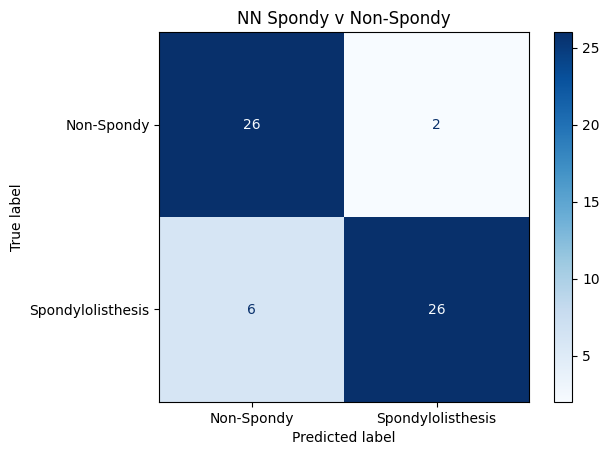

In [52]:
print(
    f'Accuracy: {accuracy_score(y_spondy_test_onehot, (best_spondy_model.predict(X_spondy_test_scaled) > 0.5).astype(int)):.4f}'
)
print(
    f'F1 Score: {f1_score(y_spondy_test_onehot, (best_spondy_model.predict(X_spondy_test_scaled) > 0.5).astype(int), average="weighted")}'
)
print(
    f"False Negative Rate (FNR): {false_negative_rate(confusion_matrix(y_spondy_test_onehot, (best_spondy_model.predict(X_spondy_test_scaled) > 0.5).astype(int)))[0]:.4f}"
)

ConfusionMatrixDisplay(
    confusion_matrix=confusion_matrix(
        y_spondy_test_onehot,
        (best_spondy_model.predict(X_spondy_test_scaled) > 0.5).astype(int),
    ),
    display_labels=["Non-Spondy", "Spondylolisthesis"],
).plot(cmap=CMAP)
plt.title("NN Spondy v Non-Spondy")